# Project 2

## Cancer data

In [242]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [243]:
# Read the features file
features_df = pd.read_csv("/Users/anthonodengard/skolarbete/MPCAS/MVE441/Project_1/TCGAdata.txt", sep=" ")
features = features_df.to_numpy()

# Read the labels file
labels_df = pd.read_csv("/Users/anthonodengard/skolarbete/MPCAS/MVE441/Project_1/TCGAlabels", sep=" ")
labels = labels_df.to_numpy()
labels = LabelEncoder().fit_transform(labels)


/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [244]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,  stratify=labels, random_state=42)

In [245]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

## Explore data

(array([ 172.,    0., 1215.,    0.,  266.,    0.,  571.,    0.,  606.,
          57.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

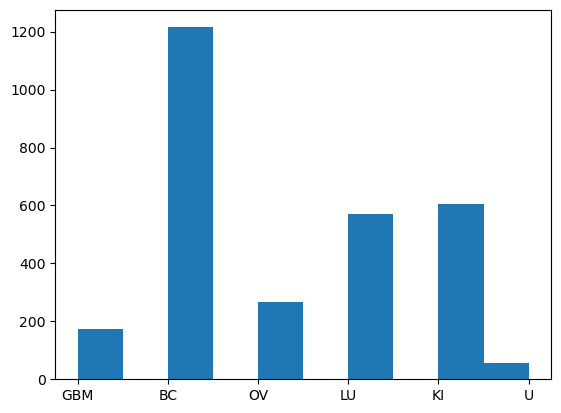

In [246]:
plt.hist(labels_df)

### Unbalanced dataset.

## Create noisy dataset

In [247]:
def noise_function(dataframe, mean, std_dev):
    noise = np.random.normal(mean, std_dev, size=dataframe.shape)
    dataframe = dataframe + noise
    return dataframe

def create_noisy_dataset(features, labels, mean, std_dev):
    dataframe = noise_function(features, mean, std_dev)
    return dataframe


Noise is introduced through the addition of normally distributed noise with a mean of zero to every element within both the training and testing datasets. The extent of noise is specified by the standard deviation.

In [248]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn import clone


In [249]:
def eval_model_performance(model, X_train, X_test, y_train, y_test, noise_levels):
    train_performance = []
    test_performance = []
    models = []
    for noise_level in noise_levels:
        model = clone(model)
        # Scale and transform
        X_train_noise = create_noisy_dataset(X_train, y_train, 0, noise_level)
        X_test = create_noisy_dataset(X_test, y_test,0, noise_level)
        scaler = StandardScaler().fit(X_train_noise)
        X_test_noise = scaler.transform(X_test)
        X_train_noise = scaler.transform(X_train_noise)
        
        model.fit(X_train_noise, y_train)
        y_pred_train = model.predict(X_train_noise)
        y_pred_test = model.predict(X_test_noise)
        
        models.append(model)
        train_performance.append([accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train, average='macro')])
        test_performance.append([accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test,average='macro')])
        
    return train_performance, test_performance, models
        

In [250]:
noise_levels = np.arange(0,15,3)
random_forest_classifier = RandomForestClassifier()
train_performance_RF, test_performance_RF, models_RF = eval_model_performance(random_forest_classifier,X_train, X_test, y_train, y_test, noise_levels)


In [251]:
import matplotlib.pyplot as plt

def plot_performance(performance_data, model_name, noise_levels):
    accuracy_scores = [entry[0] for entry in performance_data]
    f1_scores = [entry[1] for entry in performance_data]
    plt.figure(figsize=(8, 6))
    plt.plot(noise_levels, accuracy_scores, label='accuracy_score')
    plt.plot(noise_levels, f1_scores, label='f1_score')
    plt.title(model_name + ' Classifier Performance')
    plt.legend()
    plt.xlabel('Noise level')
    plt.grid(True)
    plt.show()


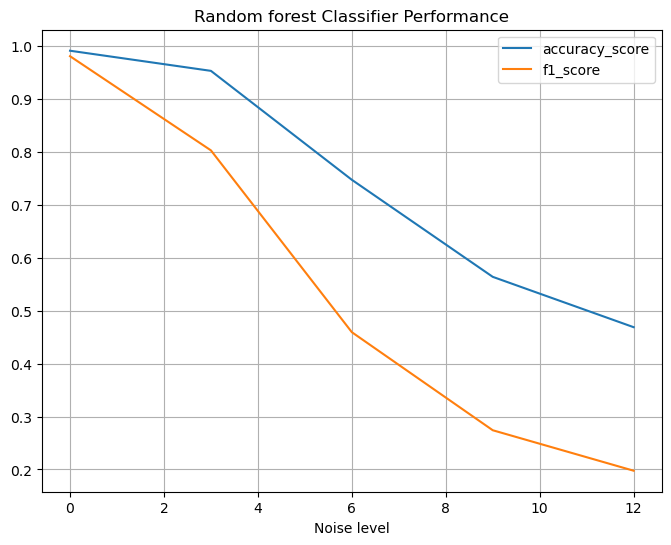

In [252]:
plot_performance(test_performance_RF, "Random forest",noise_levels)

In [253]:
from xgboost import XGBClassifier
noise_levels = np.arange(0,15,3)
XGboost_classifier = XGBClassifier()
train_performance_boosting, test_performance_boosting, models_XGboost = eval_model_performance(XGboost_classifier, X_train, X_test, y_train, y_test, noise_levels)

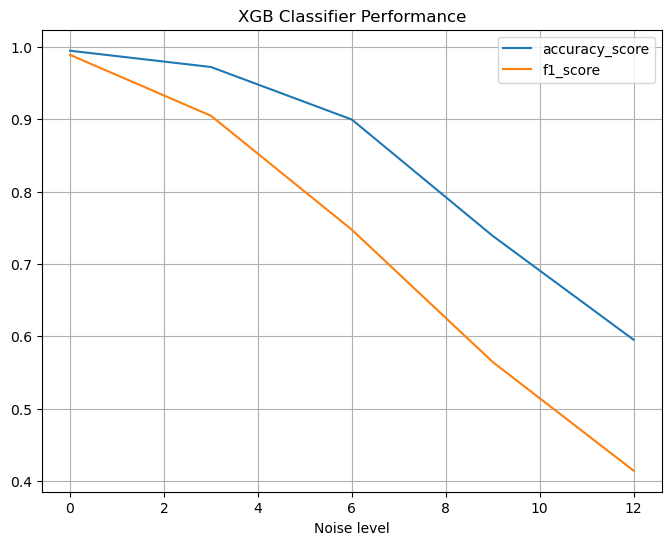

In [254]:
plot_performance(test_performance_boosting,"XGB",noise_levels)

Investigating the impact of noise levels on the performance of both random forest and XGBoost classifiers, we observed a consistent trend where both F1 score and accuracy exhibited a gradual decrease with increasing noise levels. This phenomenon suggests that higher levels of noise introduce complexity and ambiguity into the classification task, resulting in decreased model performance. The observed linear relationship underscores the sensitivity of both classifiers to noisy input data.

In [255]:
def plot_feature_importance(model, data, noise_levels, number_of_features, x_ticks):

    for i in range(len(noise_levels)):
        importances = model[i].feature_importances_
        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]
        indices = indices[0:number_of_features]


        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(data.columns[indices], importances[indices], align="center")
        plt.xlabel("") 
        plt.xlabel("Feature")
        plt.ylabel("Feature Importance")
        plt.title(type(model[i]).__name__+ r" Feature Importance, $\sigma$ = " + str(noise_levels[i]))
        if x_ticks == False:
            plt.xticks([])
    plt.show()

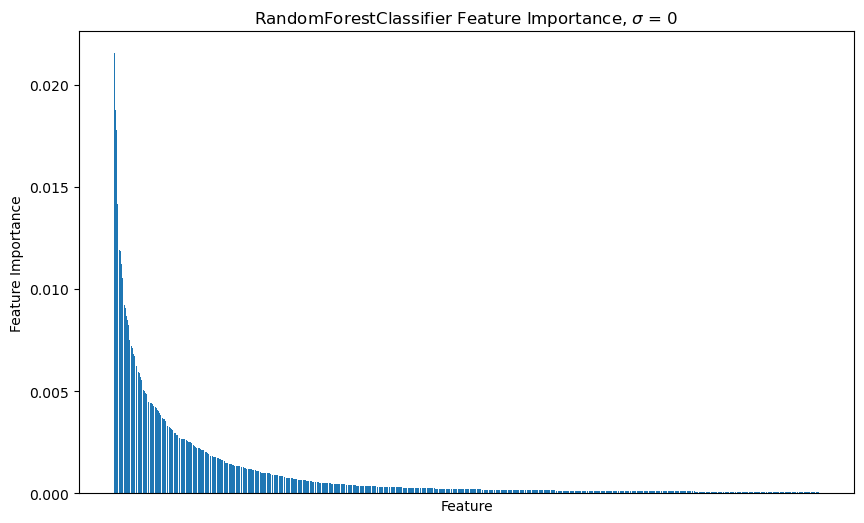

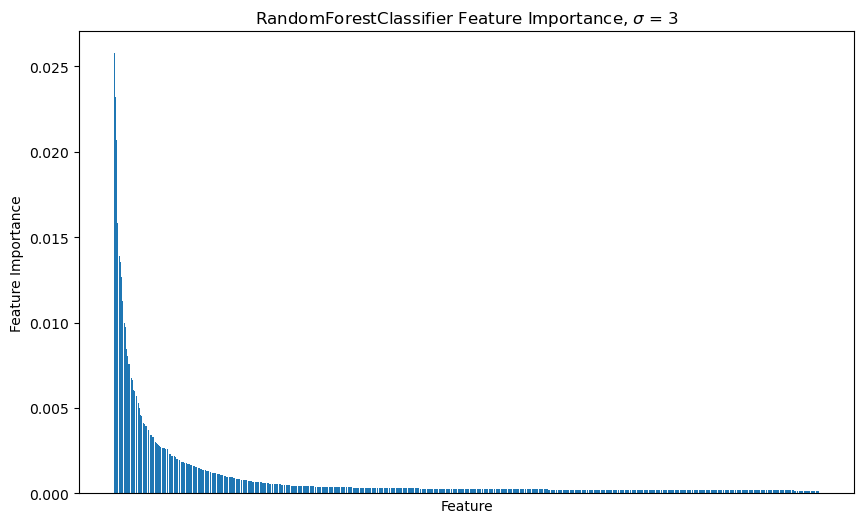

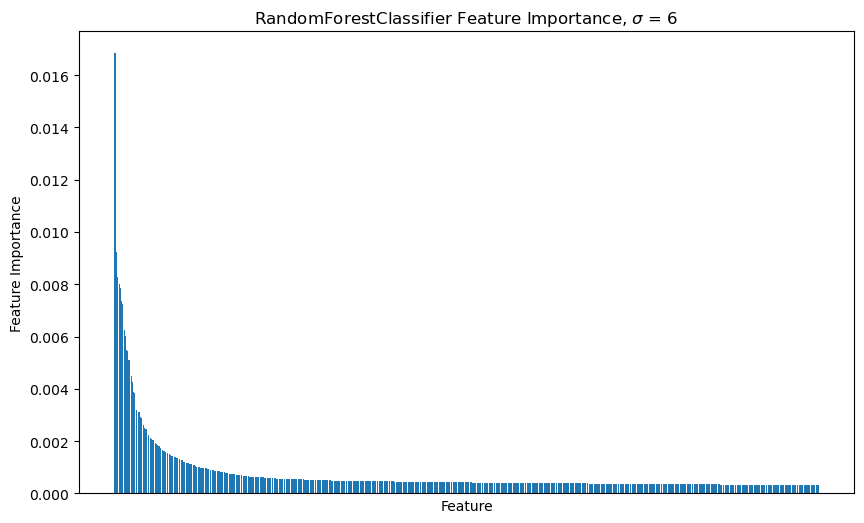

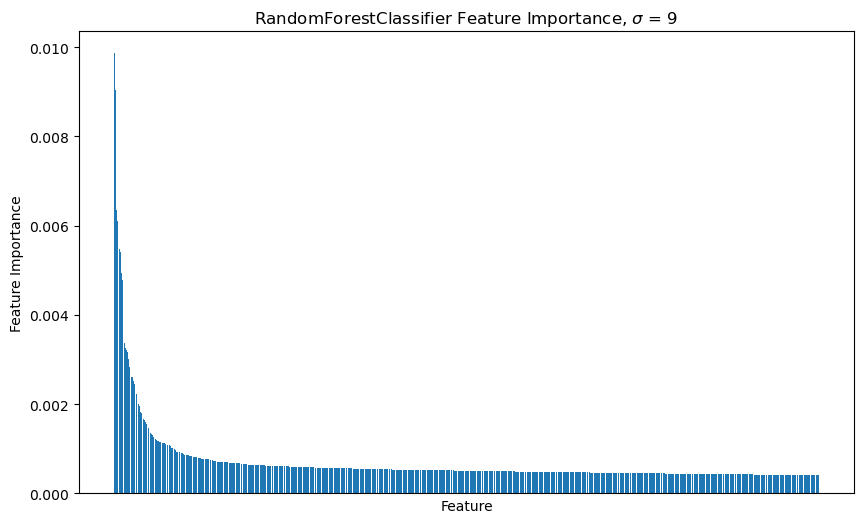

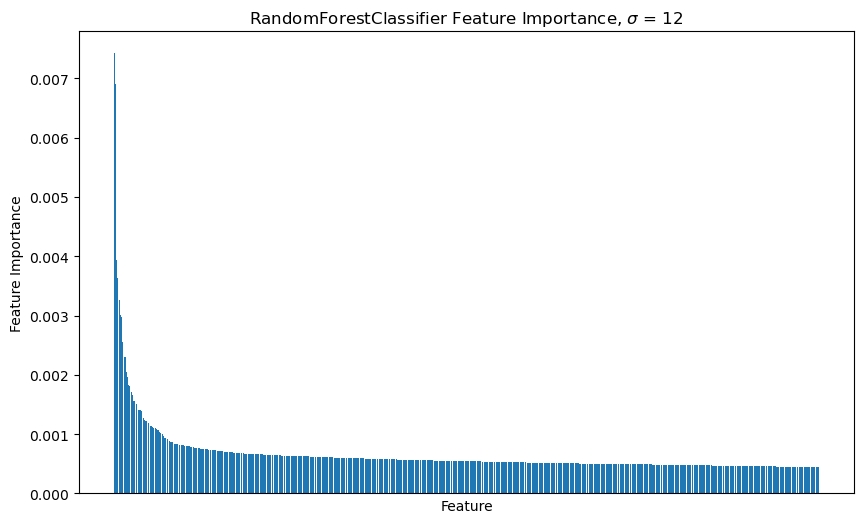

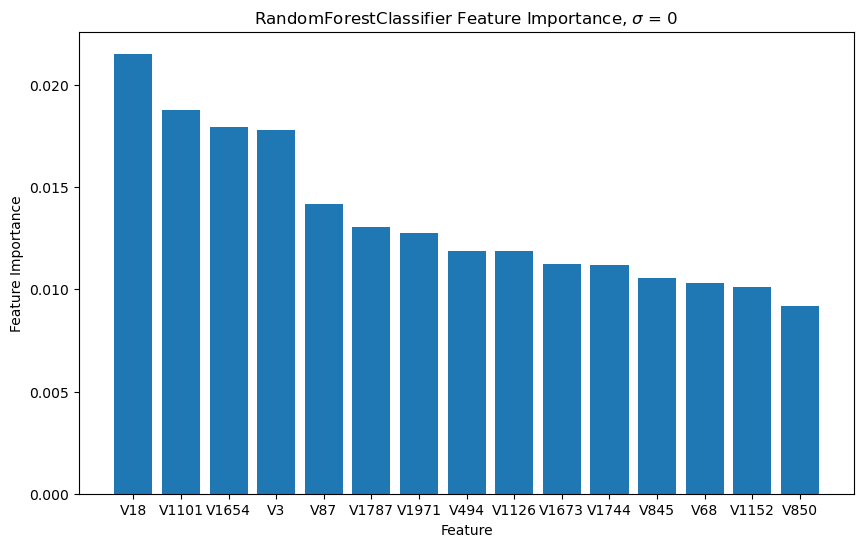

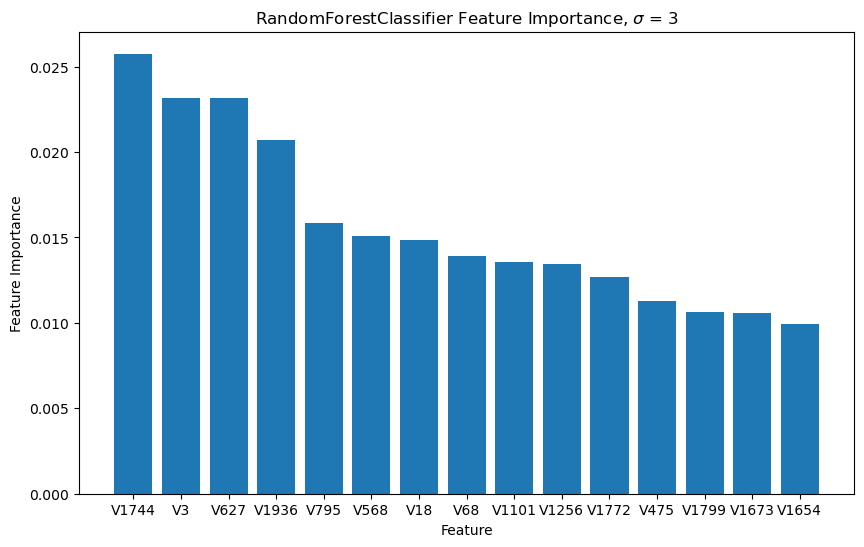

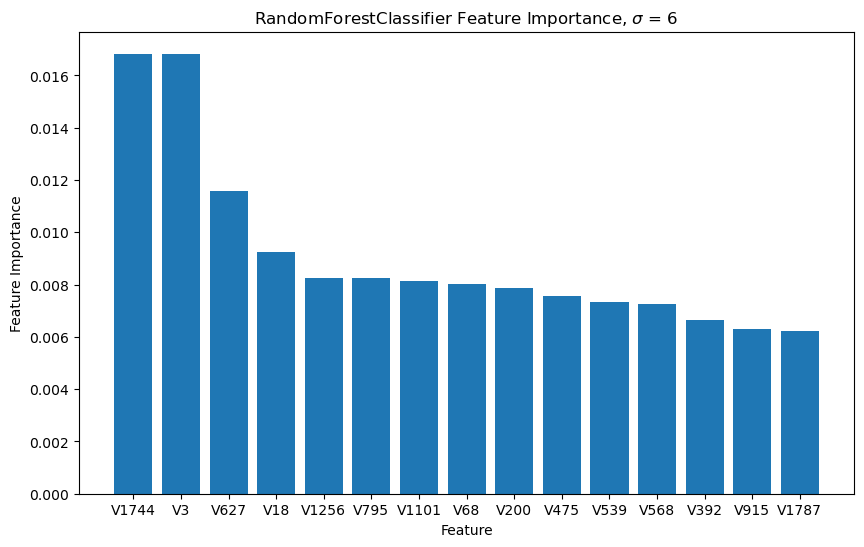

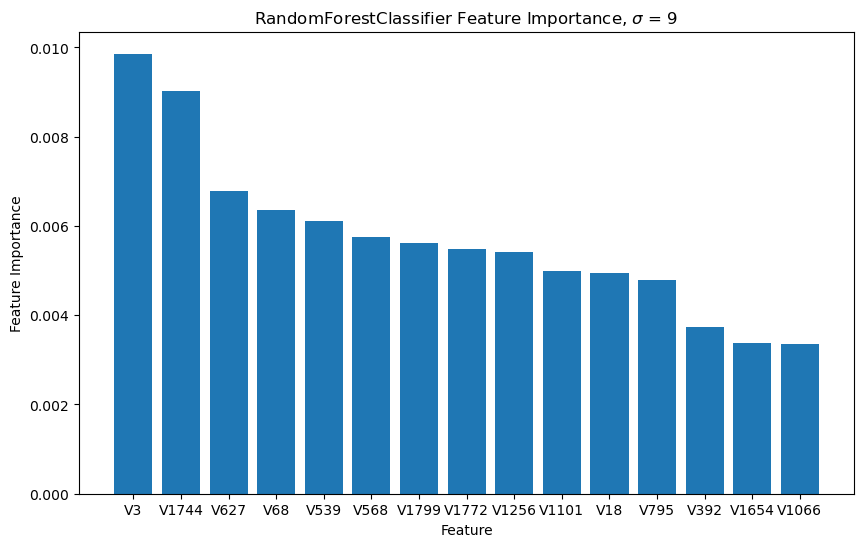

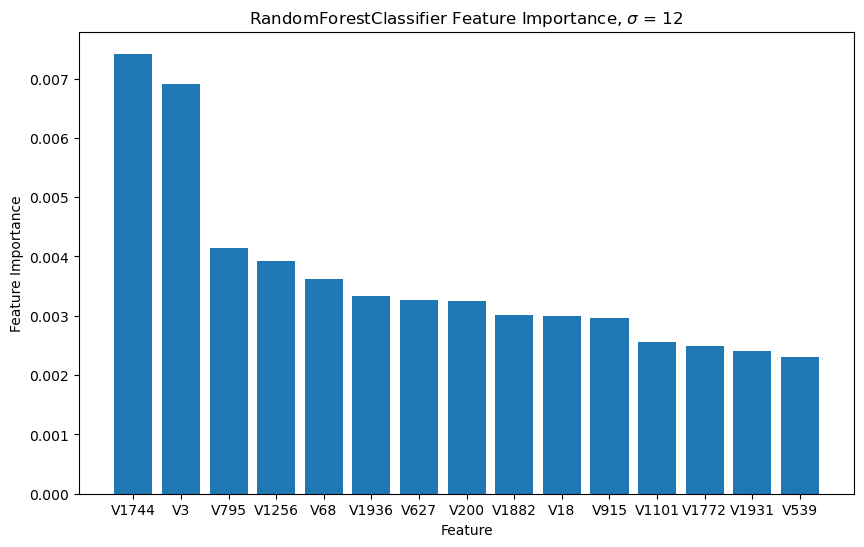

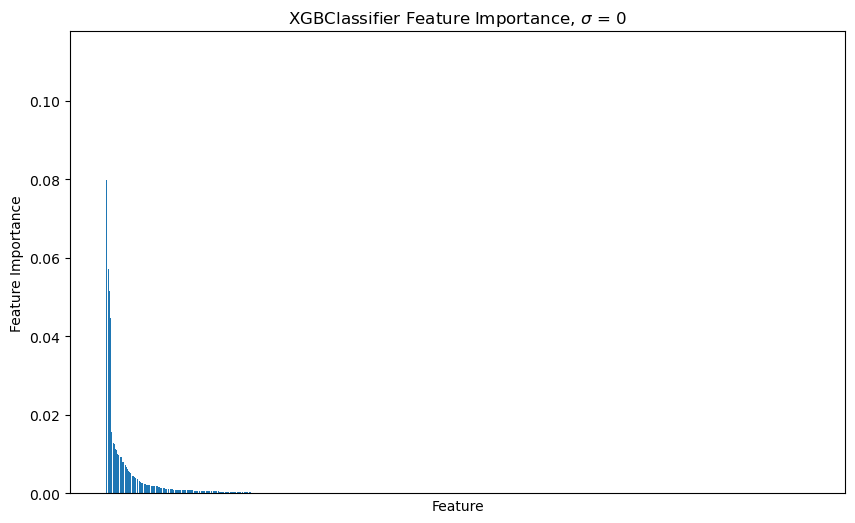

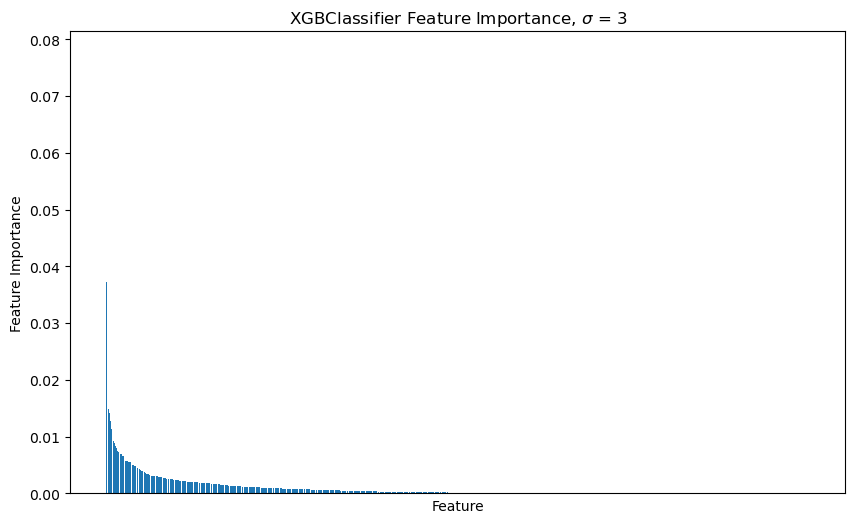

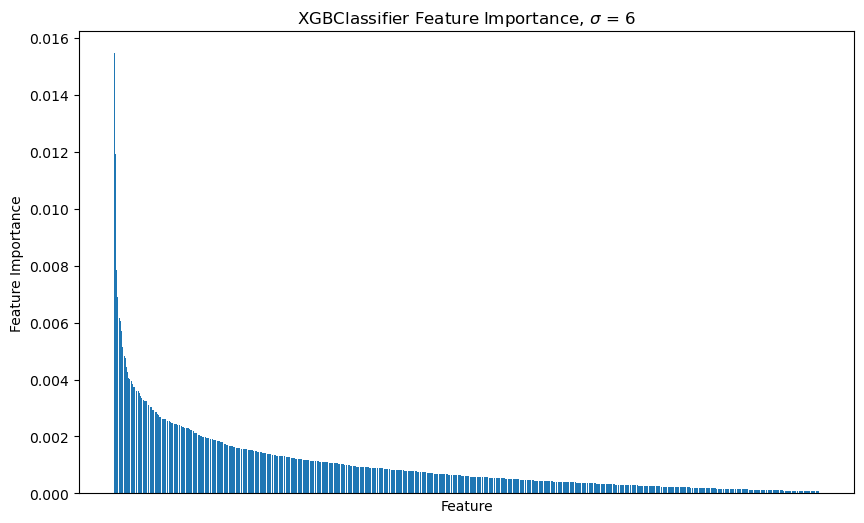

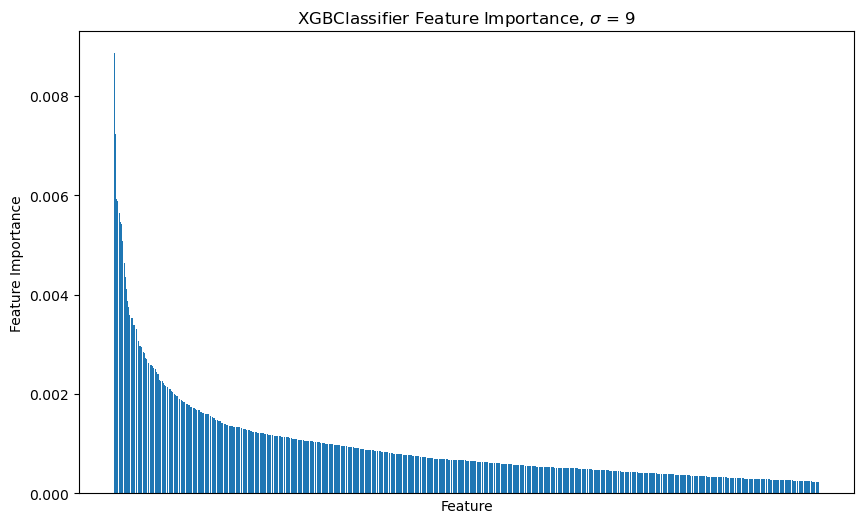

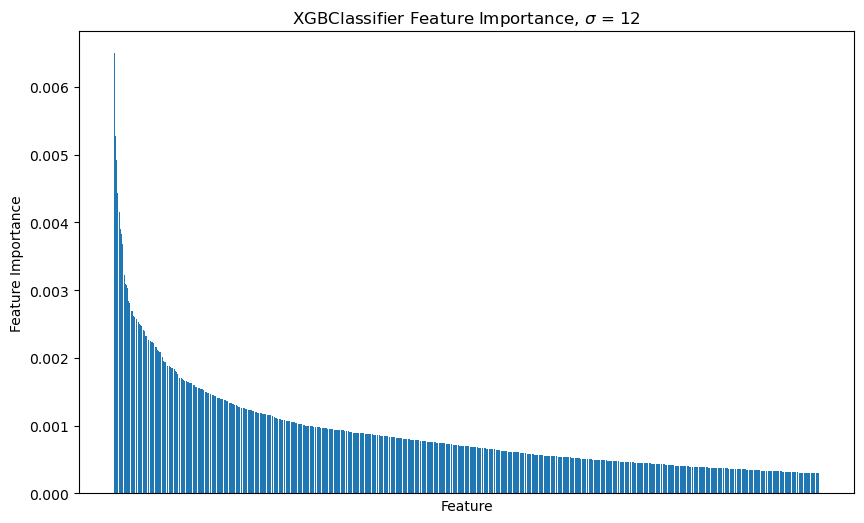

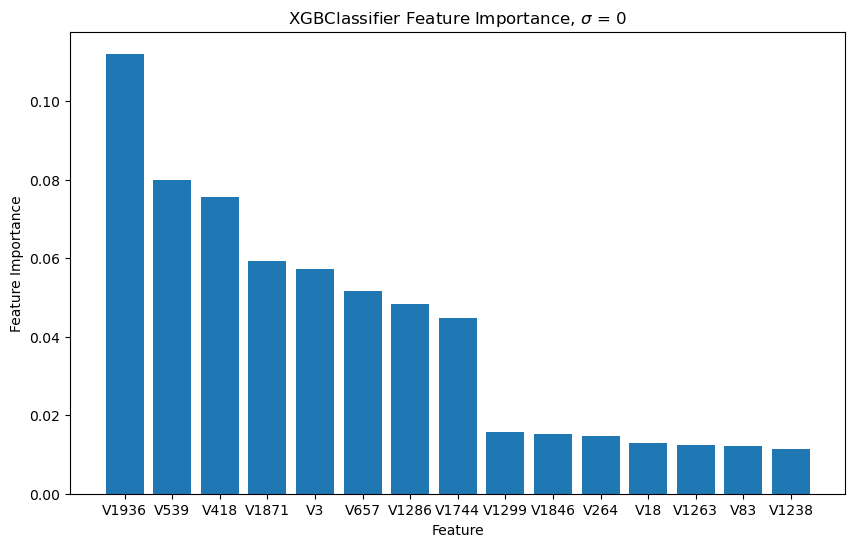

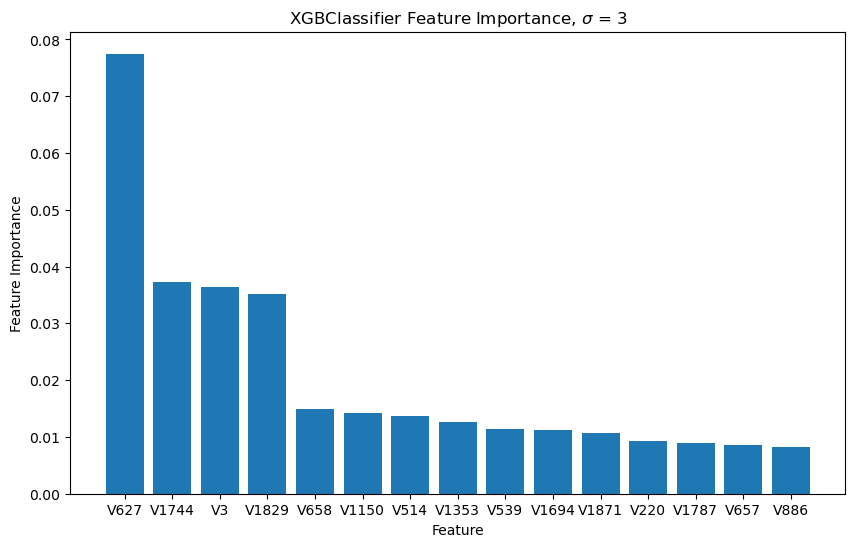

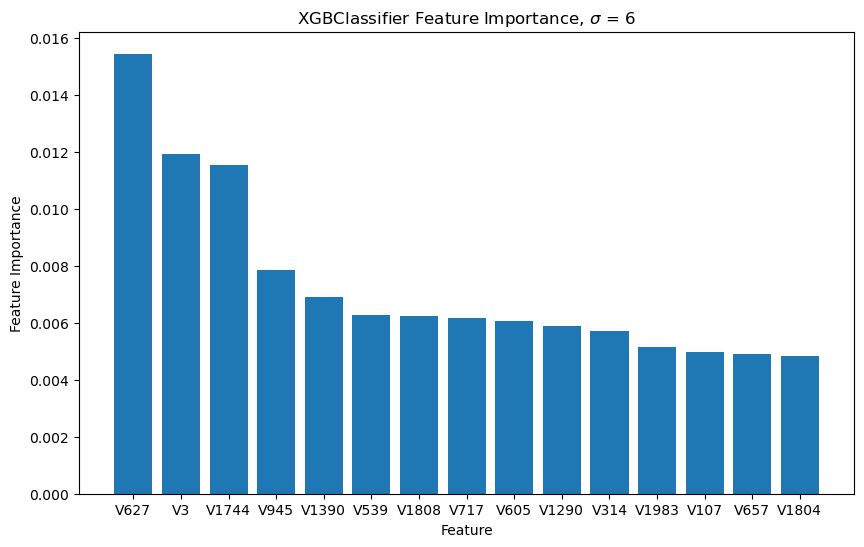

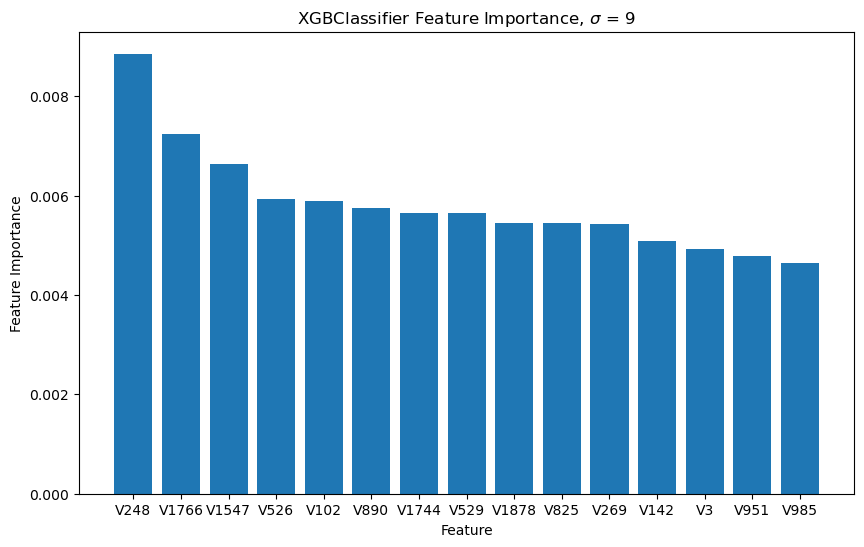

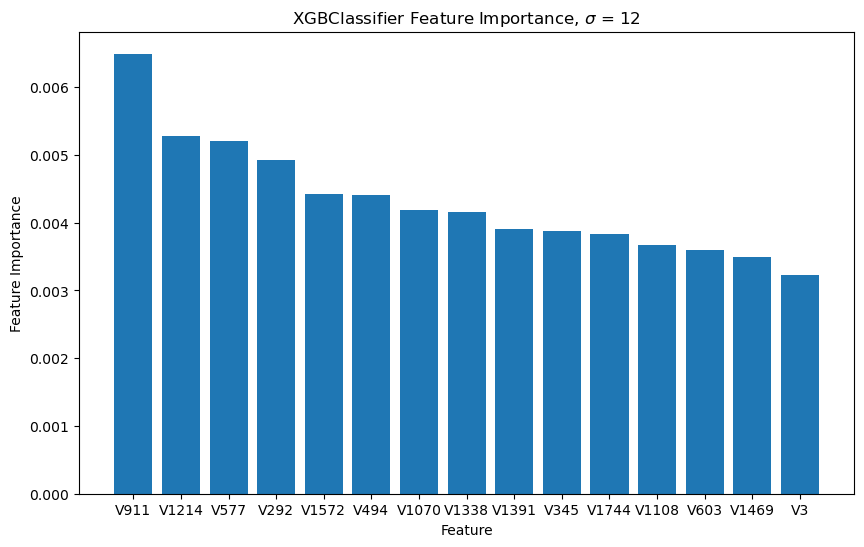

In [256]:
plot_feature_importance(models_RF, features_df, noise_levels, 1000, False)
plot_feature_importance(models_RF, features_df, noise_levels, 15, True)
plot_feature_importance(models_XGboost,features_df, noise_levels, 1000, False)
plot_feature_importance(models_XGboost,features_df, noise_levels, 15, True)

Between the models, we note that XGBoost seem to rely on fewer features then RandomForest. This can be attributed to the underlying mechanism of the algorithms. 

XGBoost employs a gradient boosting algorithm, sequentially building an ensemble of weak learners (typically decision trees) in an additive manner. Each subsequent learner focuses on minimizing the errors of the previous ones, prioritizing a subset of features most effective in reducing the overall loss function. Consequently, XGBoost emphasizes a smaller set of informative or predictive features for the task at hand.

In contrast, Random Forest constructs an ensemble of decision trees independently and in parallel, with each tree trained on a random subset of features and samples from the dataset. This typically results in utilizing a larger number of features, aggregating the predictive power of multiple trees considering different feature subsets. While this leads to robustness and generalization, it may also result in a broader distribution of feature importance.

The observed pattern of decreasing feature importance and a more evenly distributed importance spread with increasing noise levels is not unique to the Random Forest classifier but is also evident in the XGBoost classifier. This consistency across classifiers underscores the robustness of the observed phenomenon and suggests a common adaptive response to noisy input data. Similar to the Random Forest classifier, the XGBoost classifier showcases a diminishing reliance on individual features and a trend towards incorporating a broader array of features into its decision-making process as noise levels escalate

Furthermore, it is noteworthy that the most important features vary with different levels of noise, indicating the deterioration of discernible patterns in the data. This variability underscores the classifier's ability to adapt to the changing characteristics of the input data.

In [257]:

def plot_permutation_importance(importances, features, models):

    for i in range(len(importances)):
        mean_importances = importances[i].importances_mean
        # Sort feature importances in descending order
        indices = np.argsort(mean_importances)[::-1]
        indices = indices[0:10]


        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(features.columns[indices], mean_importances[indices], align="center")

        plt.xlabel("Feature Index")
        plt.ylabel("Permutation Importance")
        plt.title(type(models[i]).__name__+ r" Permutation Importance, $\sigma$ = ")
    plt.show()


In [258]:
# Read the features file
cd_features_df_load = pd.read_csv("CATSnDOGS.csv", delimiter=',').dropna(axis=1)

# Read the labels file
cd_labels_df = pd.read_csv("Labels.csv", delimiter=',').dropna(axis=1)
cd_features_df = StandardScaler().fit_transform(cd_features_df_load)

labels_cd = cd_labels_df.to_numpy().ravel()
features_cd = cd_features_df_load.to_numpy()


In [259]:
X_train_cd, X_test_cd, y_train_cd, y_test_cd = train_test_split(features_cd, labels_cd, test_size=0.3, stratify=labels_cd, random_state=42)

In [260]:
def plot_grayscale_image(row):
    image_resolution = int(np.sqrt(len(row)))
    # Extract image data from the row
    image_data = np.array(row).reshape((image_resolution, image_resolution)).T  # Assuming the image data is stored in a 1D array and represents a 28x28 image
    # Plot the grayscale image
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title('Grayscale Image')
    plt.show()


In [261]:
import random

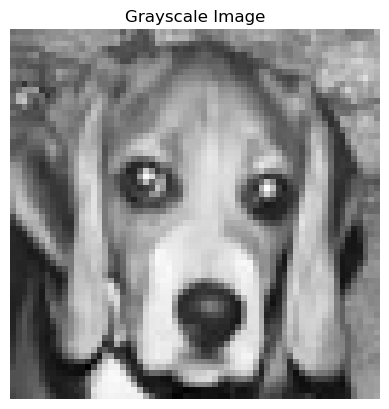

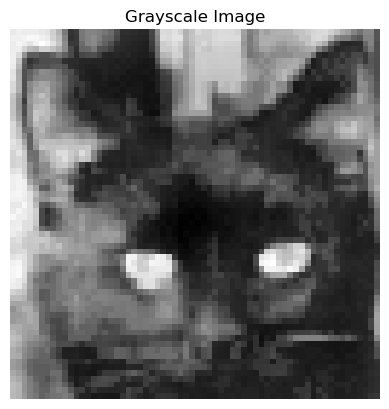

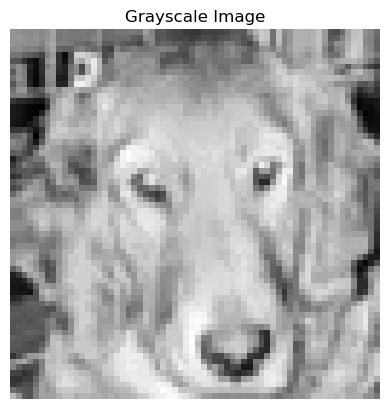

In [262]:
random_indexs = [random.randint(0,100) for i in range(3)]

for index in random_indexs:
    plot_grayscale_image(cd_features_df[index])

In [263]:
def permute_normal_distribution_replace(matrix, percent,mean, var):
    # Flatten the matrix to a 1D array
    flat_matrix = matrix.flatten()

    # Calculate the number of elements to permute
    num_elements = len(flat_matrix)
    num_permute = int(percent * num_elements)

    # Randomly select indices to permute
    permute_indices = np.random.choice(num_elements, num_permute, replace=False)

    # Permute selected indices to normally distributed values
    flat_matrix[permute_indices] = np.random.normal(size=num_permute, loc=mean, scale=var)

    # Reshape the flattened array back to a 64x64 matrix
    permuted_matrix = flat_matrix.reshape(matrix.shape)

    return permuted_matrix

def cd_noisy_dataset_replace(features, labels, mean, var, percentage):
    permuted_dataset = []
    for matrix in features:
        permuted_matrix = permute_normal_distribution_replace(matrix, percentage, mean, var)
        permuted_dataset.append(permuted_matrix)
    return permuted_dataset

def permute_normal_distribution_add(matrix, mean, var):
    # Flatten the matrix to a 1D array
    flat_matrix = matrix.flatten()

    # Calculate the number of elements to permute
    num_elements = len(flat_matrix)

    # Permute selected indices to normally distributed values
    flat_matrix = flat_matrix + np.random.normal(mean, var, size=num_elements)

    # Reshape the flattened array back to a 64x64 matrix
    permuted_matrix = flat_matrix.reshape(matrix.shape)

    return permuted_matrix

def cd_noisy_dataset_add(features,labels, mean, var):
    permuted_dataset = []
    for matrix in features:
        permuted_matrix = permute_normal_distribution_add(matrix, mean, var)
        permuted_dataset.append(permuted_matrix)
    return permuted_dataset

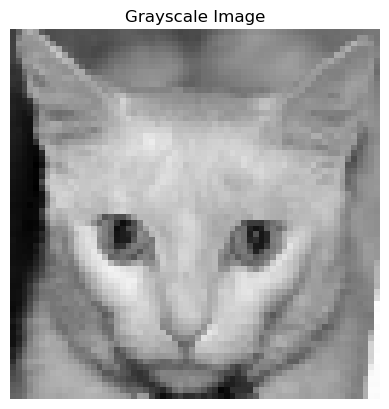

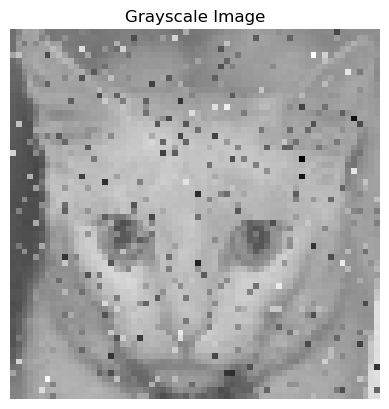

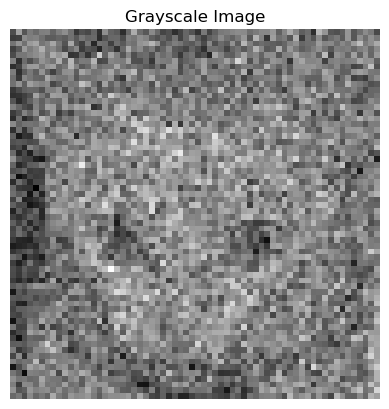

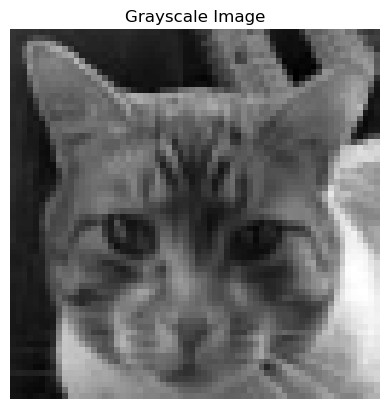

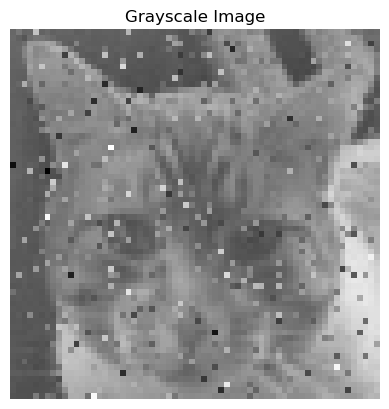

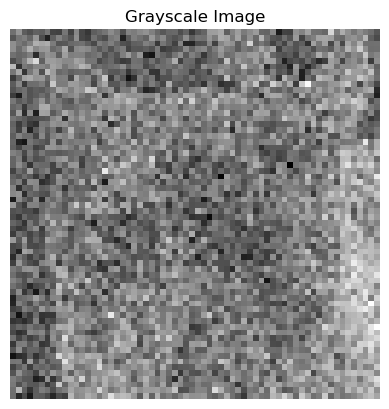

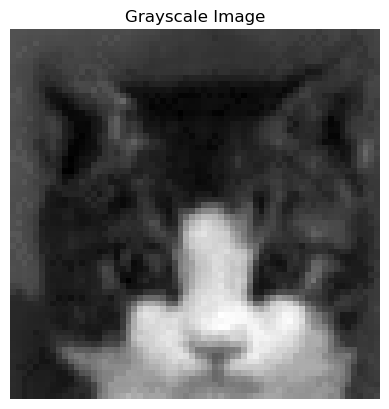

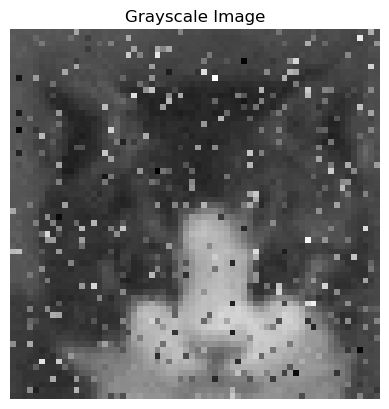

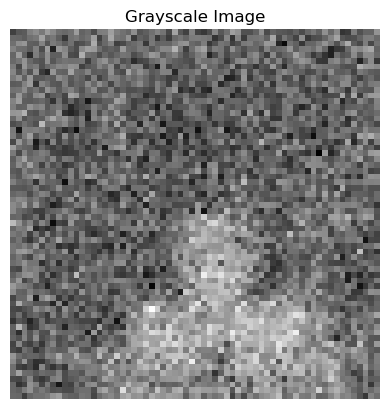

In [264]:
X_train_cd_replace= StandardScaler().fit_transform(cd_noisy_dataset_replace(cd_features_df, cd_labels_df, 0, 1, 0.1))
X_train_cd_add = StandardScaler().fit_transform(cd_noisy_dataset_add(cd_features_df, cd_labels_df, 0, 1))

random_indexs = [random.randint(0,100) for i in range(3)]

for index in random_indexs:
    plot_grayscale_image(cd_features_df [index])
    plot_grayscale_image(X_train_cd_replace[index])
    plot_grayscale_image(X_train_cd_add[index])

In [265]:
from sklearn.model_selection import cross_val_score

In [266]:
def cross_val_add(model, cd_features_df, cd_labels_df, mean, noise_levels):
    cross_val_score_add = []
    for noise in noise_levels:
        X_train_cd_add, X_test_cd_add, y_train_cd_add, y_test_cd_add = cd_noisy_dataset_add(cd_features_df, cd_labels_df, mean, noise)
        cross_val_score_add.append(np.mean(cross_val_score(model, X_train_cd_add, y_train_cd_add)))
    return cross_val_score_add

def cross_val_replace(model, cd_features_df, cd_labels_df, mean, noice_percentage):
    cross_val_score_replace = []
    for percentage in noice_percentage:
        X_train_cd_add, X_test_cd_add, y_train_cd_add, y_test_cd_add = cd_noisy_dataset_replace(cd_features_df, cd_labels_df, mean, 1, percentage)
        cross_val_score_replace.append(np.mean(cross_val_score(model, X_train_cd_add, y_train_cd_add)))
    return cross_val_score_replace

def eval_model_performance_image(model, X_train, X_test, y_train, y_test, noise_levels ,noise_type):
    train_performance = []
    test_performance = []
    models = []

    for noise_level in noise_levels:
        model = clone(model)
        if(noise_type == 'add'):
            X_train_noise = cd_noisy_dataset_add(X_train, y_train, 0, noise_level)
            X_test_noise = cd_noisy_dataset_add(X_test, y_test, 0, noise_level)
        else:
            X_train_noise = cd_noisy_dataset_replace(X_train, y_train, 0, 1, noise_level)
            X_test_noise = cd_noisy_dataset_replace(X_test, y_test, 0, 1, noise_level)
        # Scale and transform
        scaler = StandardScaler().fit(X_train_noise)
        X_test_noise = scaler.transform(X_test_noise)
        X_train_noise = scaler.transform(X_train_noise)
        
        model.fit(X_train_noise, y_train)
        y_pred_train = model.predict(X_train_noise)
        y_pred_test = model.predict(X_test_noise)
        
        models.append(model)
        train_performance.append([accuracy_score(y_pred_train, y_train), f1_score(y_pred_train, y_train, average='macro')])
        test_performance.append([accuracy_score(y_pred_test, y_test), f1_score(y_pred_test, y_test,average='macro')])
        
    return train_performance, test_performance, models

        
        
    

In [267]:
noise_levels_add = np.arange(0,10,1)
noise_percentage = np.arange(0,1.1,0.1)
random_forest_classifier_cd_replace = RandomForestClassifier()
random_forest_classifier_cd_add = RandomForestClassifier()

train_performance_replace, test_performance_replace, models_replace = eval_model_performance_image(random_forest_classifier_cd_replace, X_train_cd, X_test_cd, y_train_cd, y_test_cd, noise_percentage, 0)
train_performance_add, test_performance_add, models_add = eval_model_performance_image(random_forest_classifier_cd_add,  X_train_cd, X_test_cd, y_train_cd, y_test_cd, noise_levels_add, 'add')


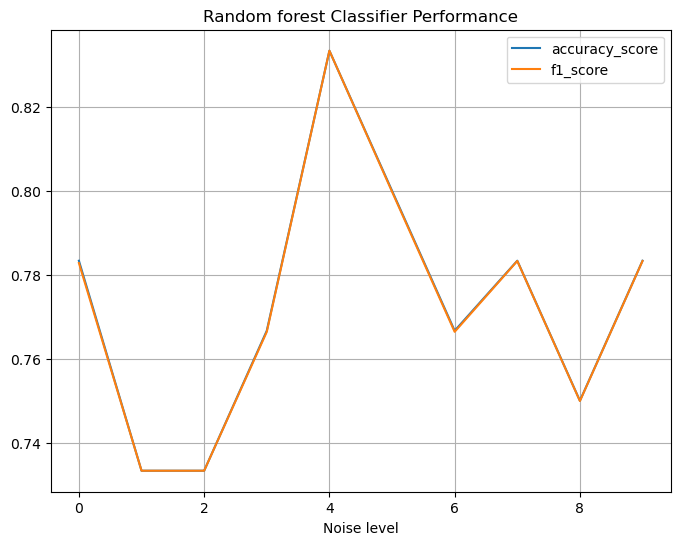

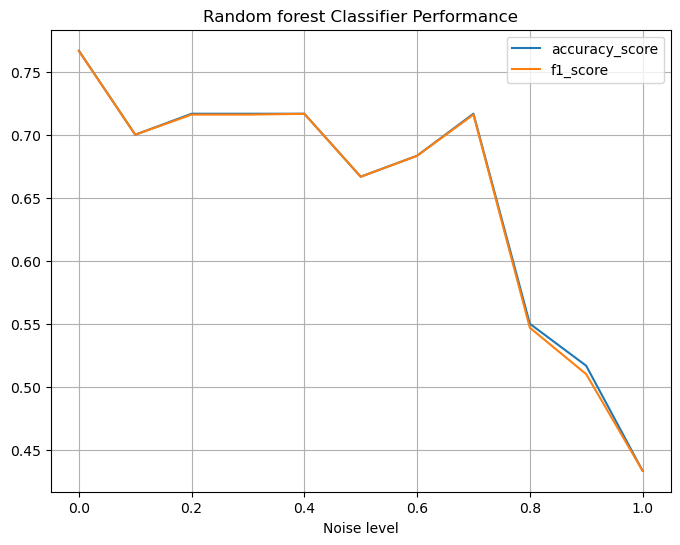

In [268]:
plot_performance(test_performance_add, "Random forest", noise_levels_add)
plot_performance(test_performance_replace, "Random forest", noise_percentage)

In [269]:
XGboost_classifier_cd_replace = XGBClassifier()
XGboost_classifier_cd_add = XGBClassifier()


train_performance_replace_xbg, test_performance_replace_xbg, models_replace_xbg = eval_model_performance_image(XGboost_classifier_cd_replace,  X_train_cd, X_test_cd, y_train_cd, y_test_cd, noise_percentage, 0)
train_performance_add_xbg, test_performance_add_xbg, models_add_xbg = eval_model_performance_image(XGboost_classifier_cd_add,  X_train_cd, X_test_cd, y_train_cd, y_test_cd, noise_levels_add, 'add')



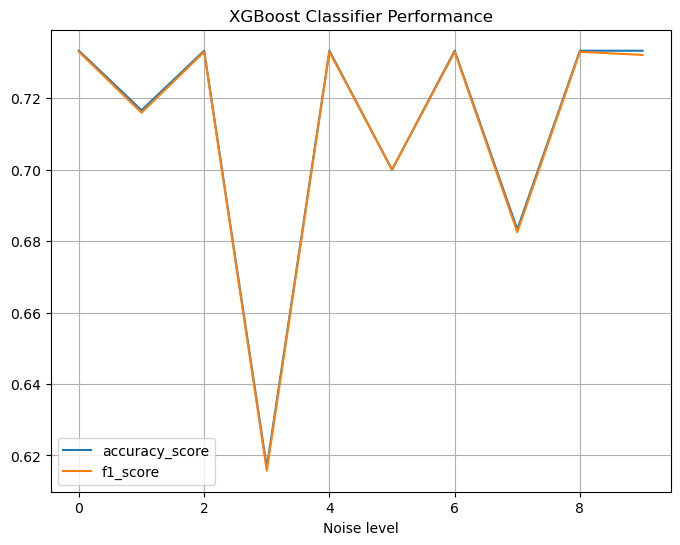

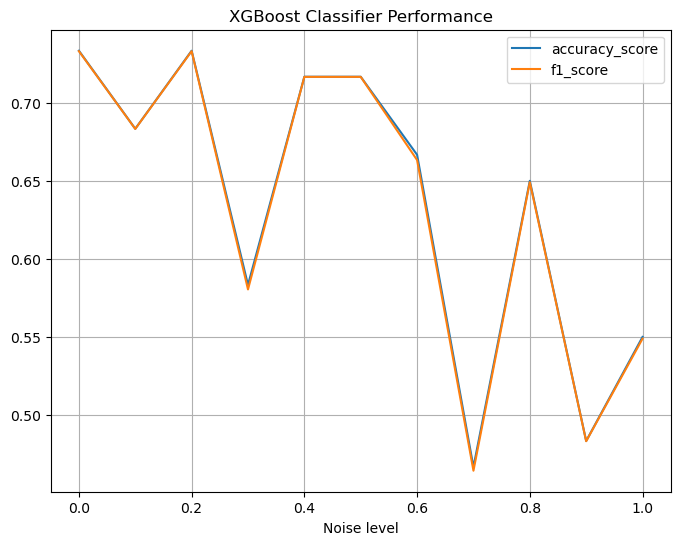

In [270]:
plot_performance(test_performance_add_xbg, "XGBoost", noise_levels_add)
plot_performance(test_performance_replace_xbg, "XGBoost", noise_percentage)


In our investigation of how noise affects image classification performance, we noticed different outcomes based on how the noise was introduced. For uniform noise addition, where noise was evenly applied to all pixels, we saw no decline in classification accuracy as noise levels rose. In cases of selective noise addition, where larger amounts of noise were introduced to a growing number of pixels, we noticed a more substantial drop in classification performance. This drop became more noticeable as more pixels were affected by the noise.

The difference in performance between uniform and selective noise addition could possibly be attributed to how each scenario affects the underlying patterns in the data. When noise is uniformly added to all pixels, the overall structure of the image remains relatively intact, allowing the classifier to still discern key features for classification. However, with selective noise addition to specific pixels, crucial patterns may be disrupted or obscured, leading to a greater impact on classification accuracy. This disruption becomes more significant as more pixels crucial to classification are affected, resulting in a more pronounced decline in performance.

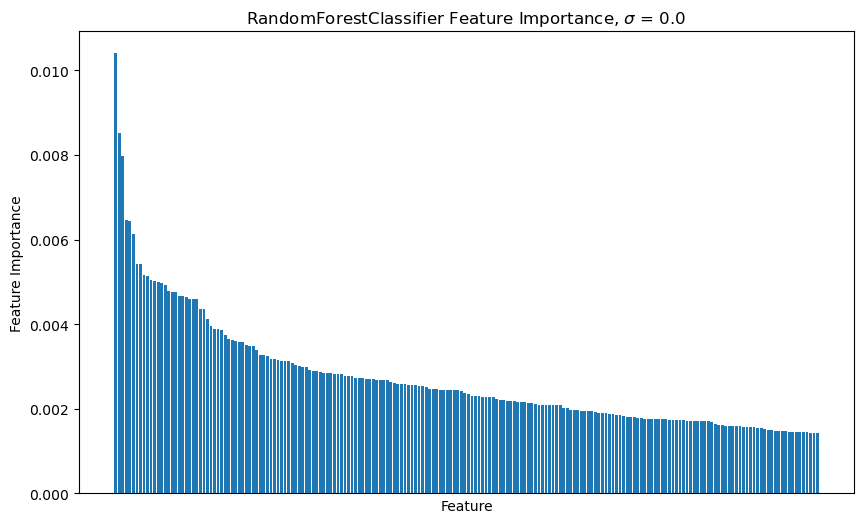

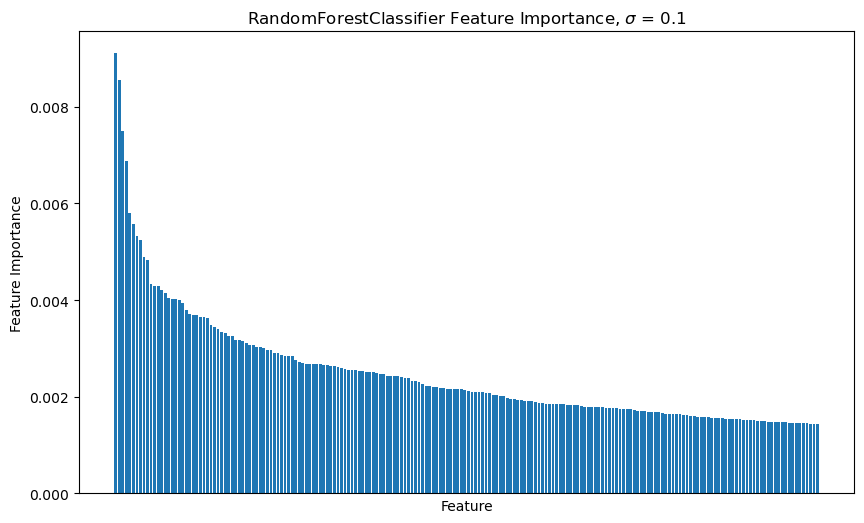

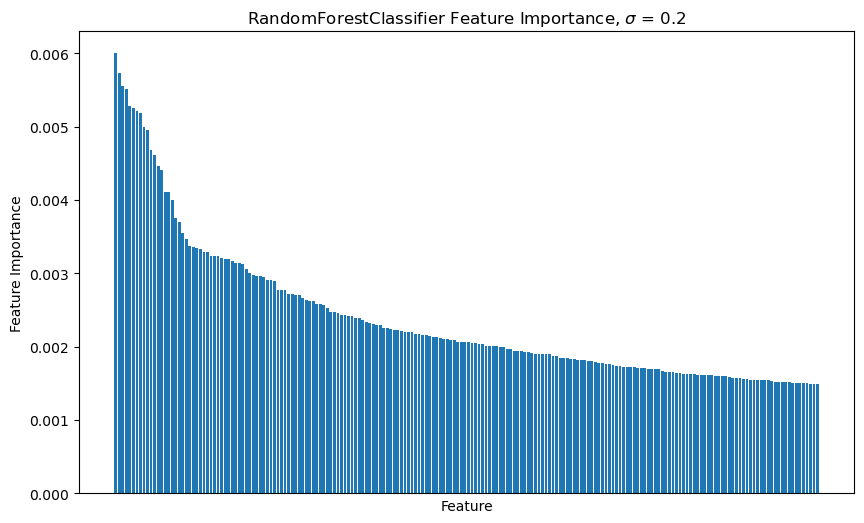

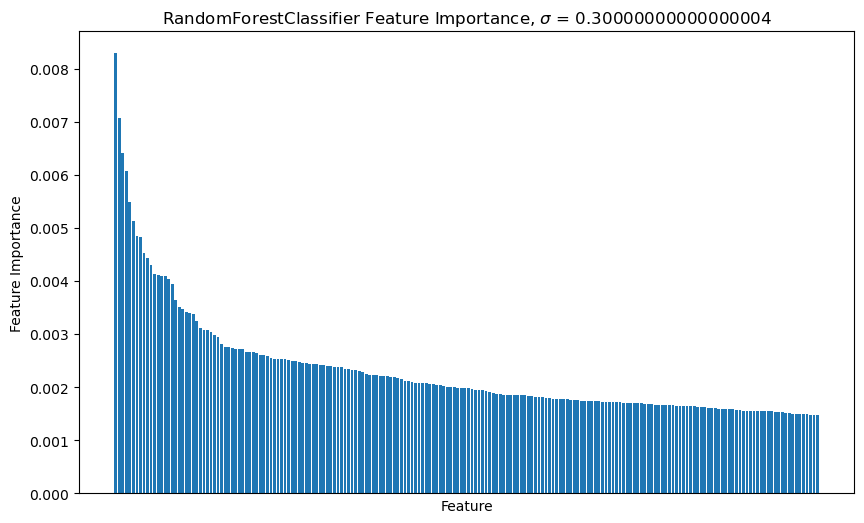

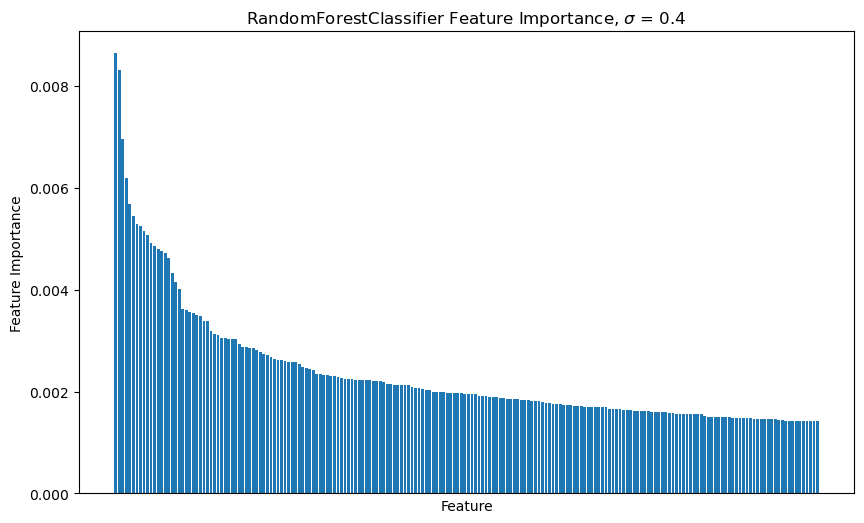

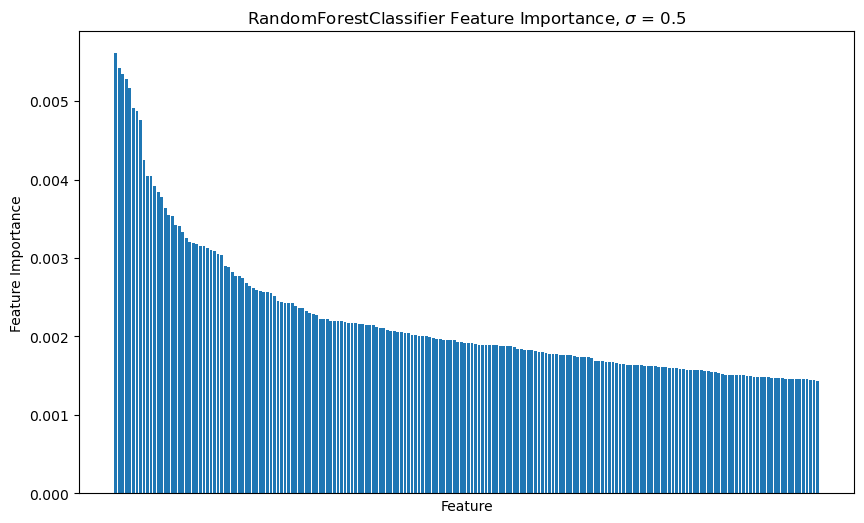

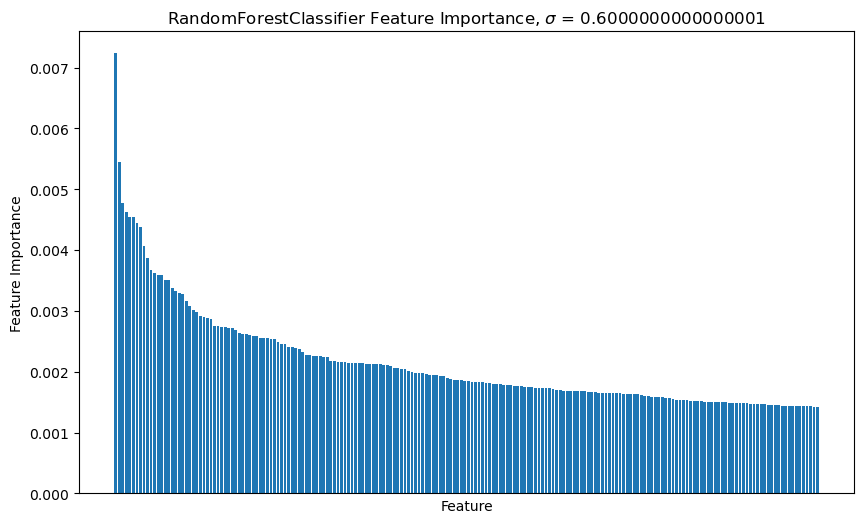

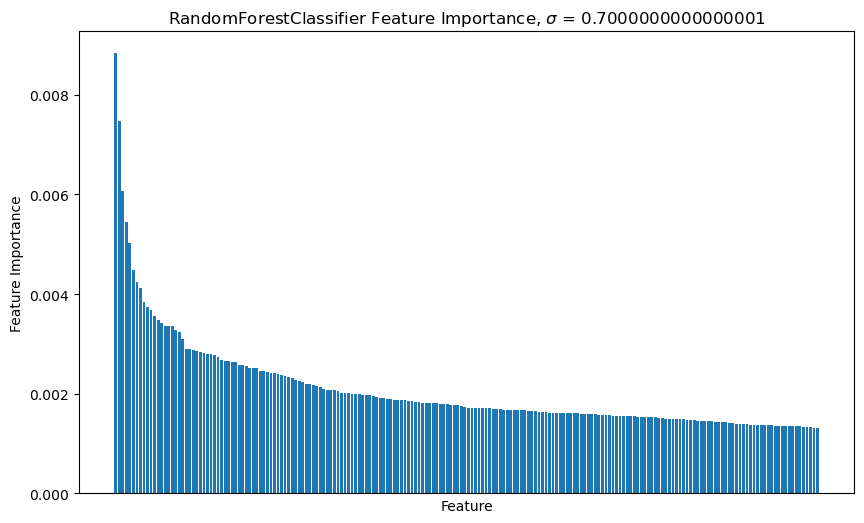

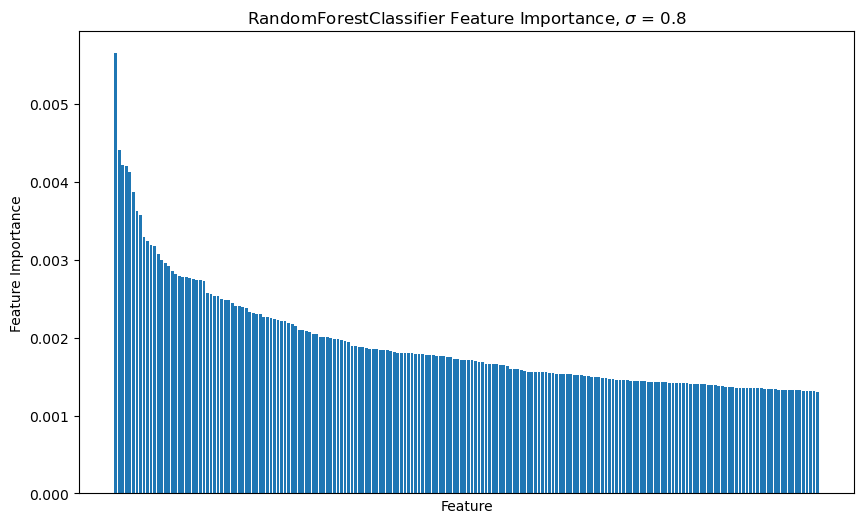

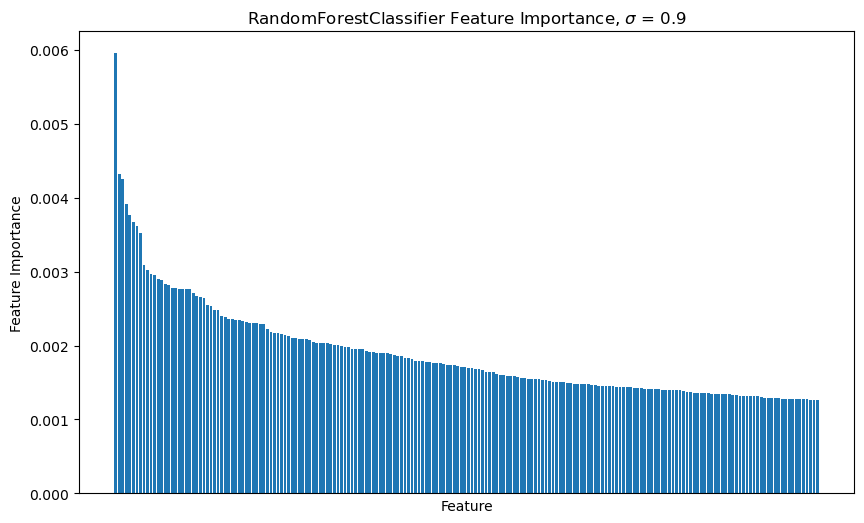

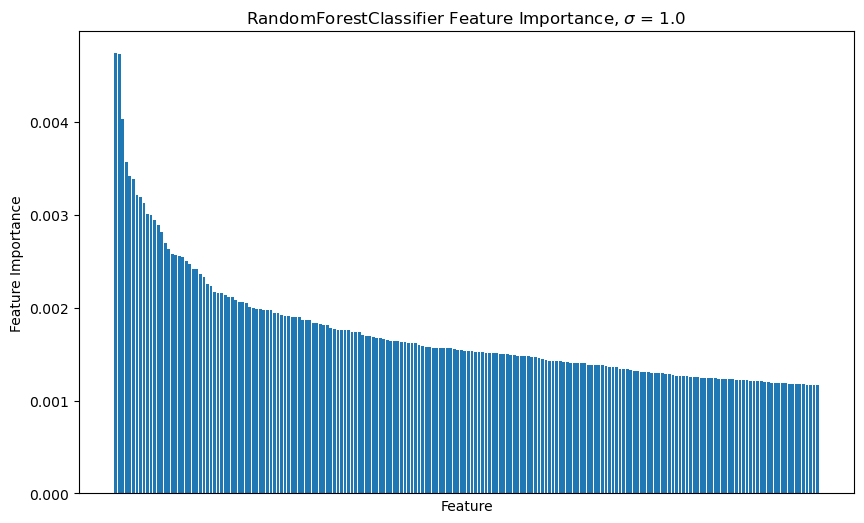

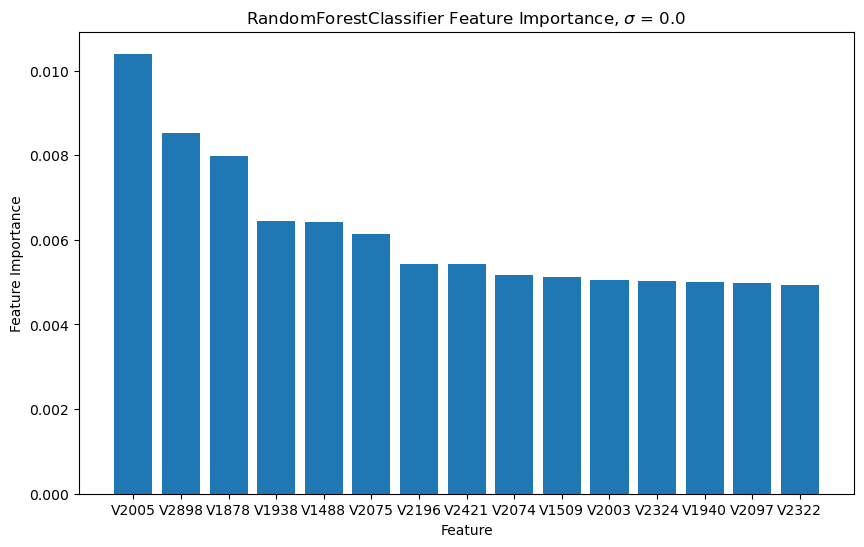

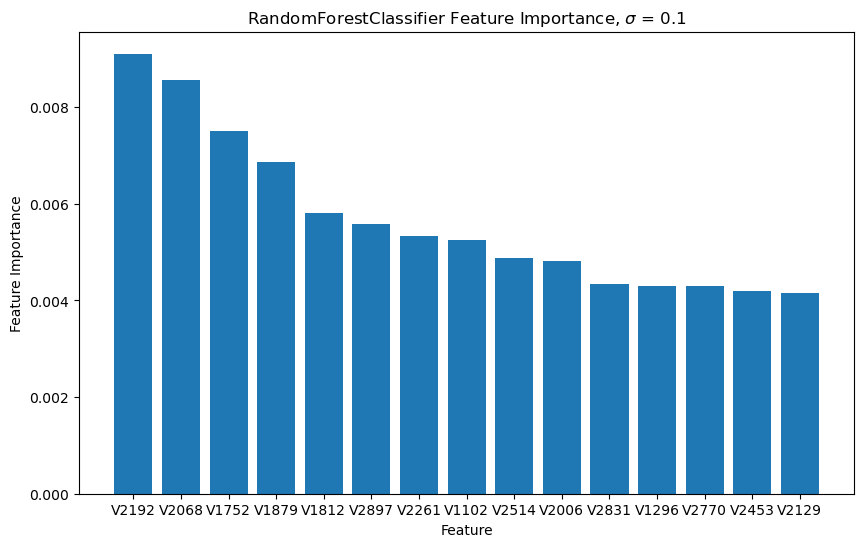

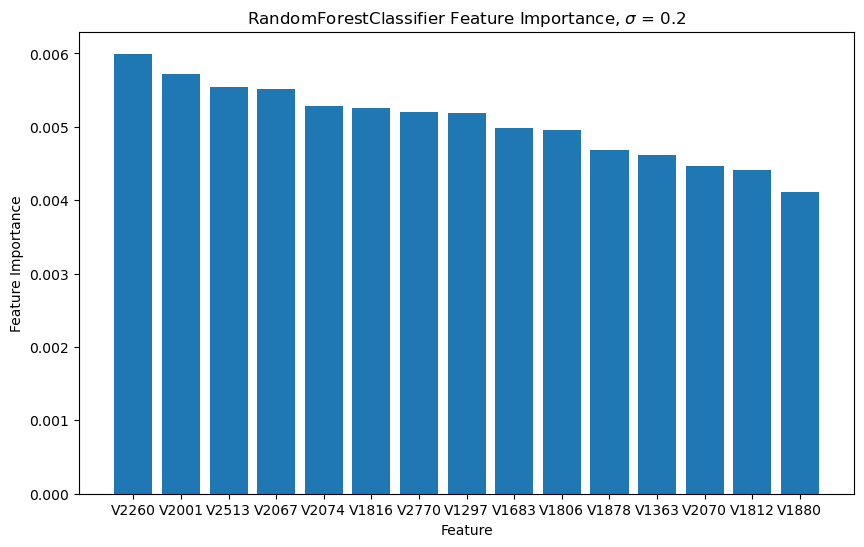

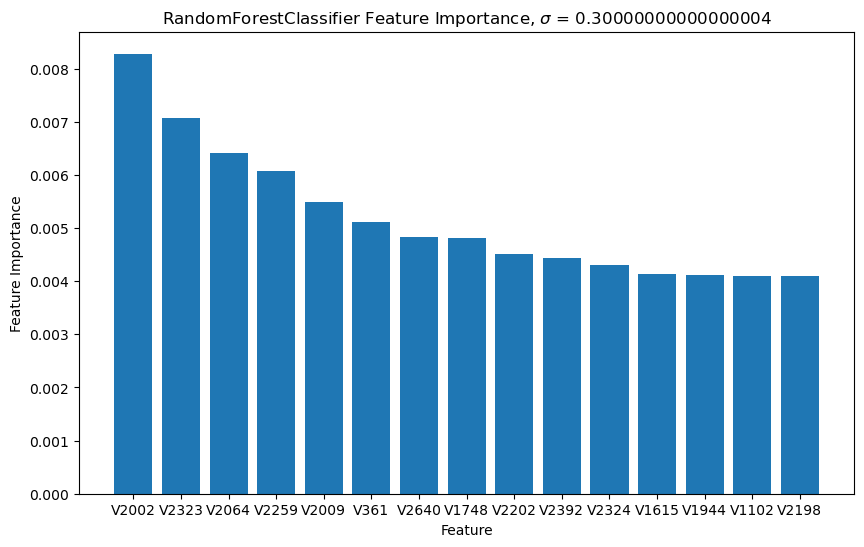

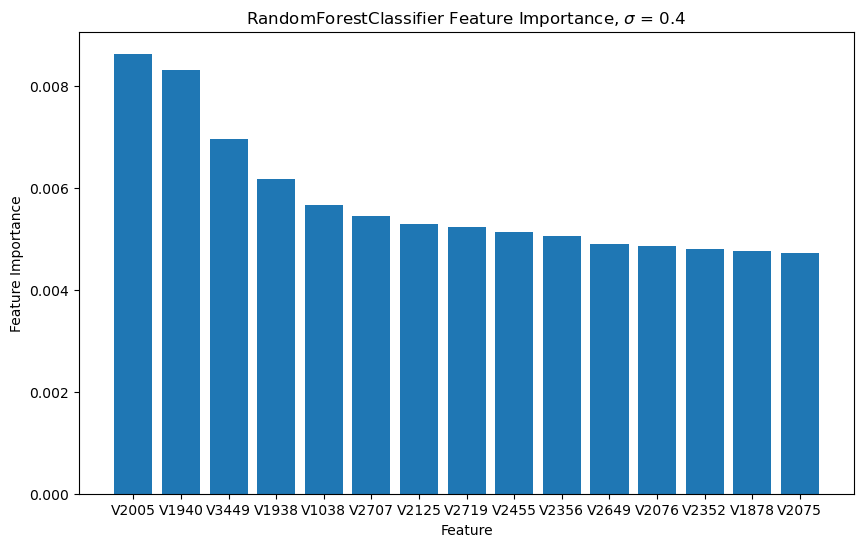

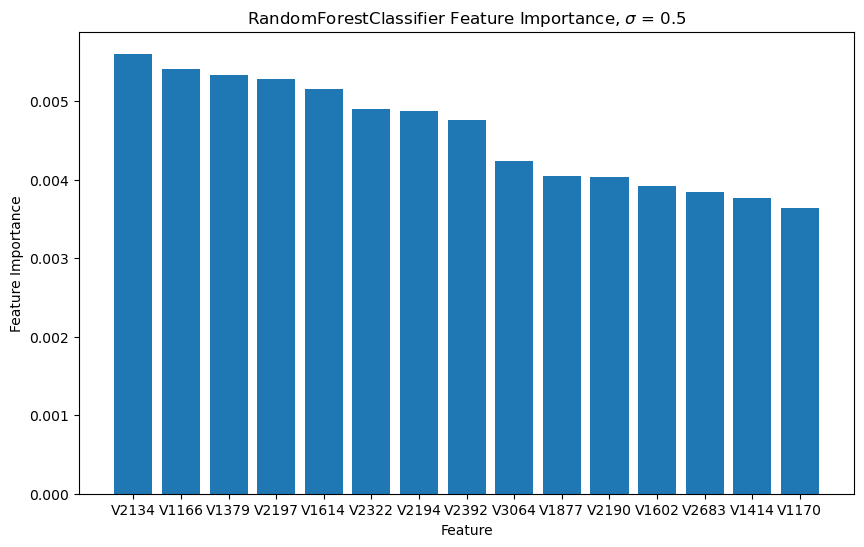

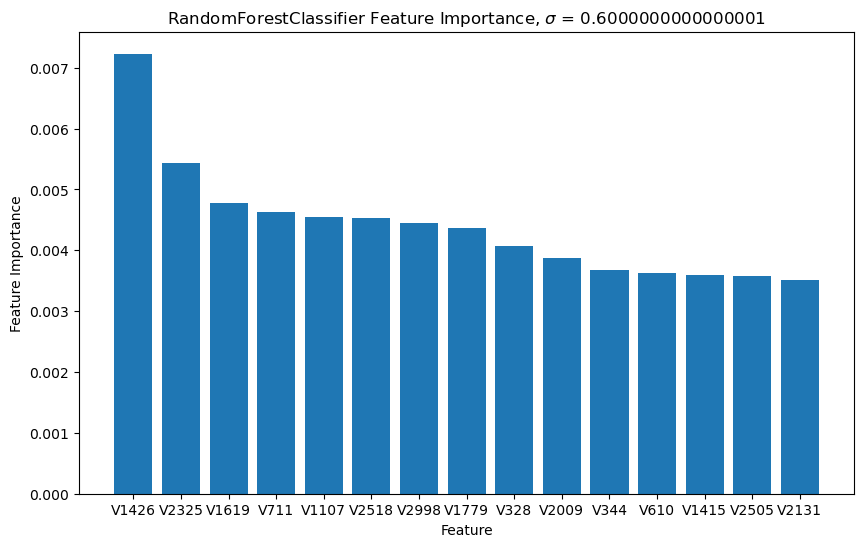

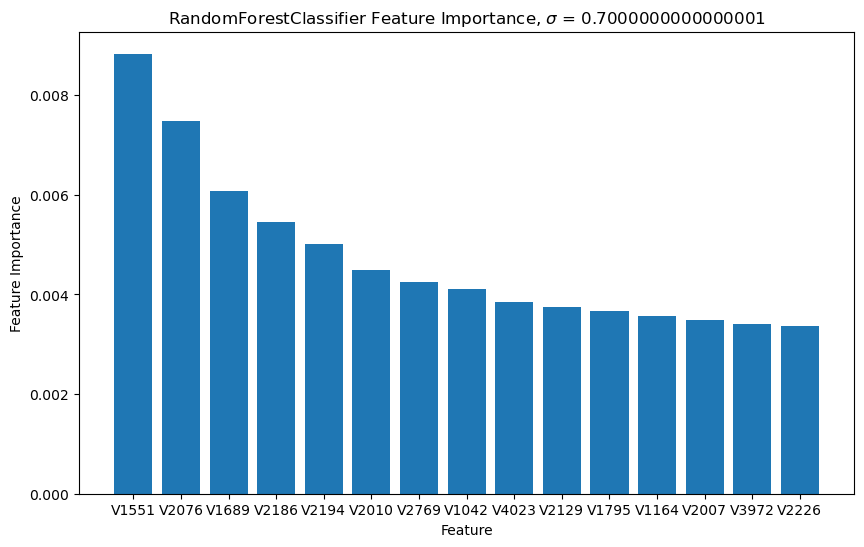

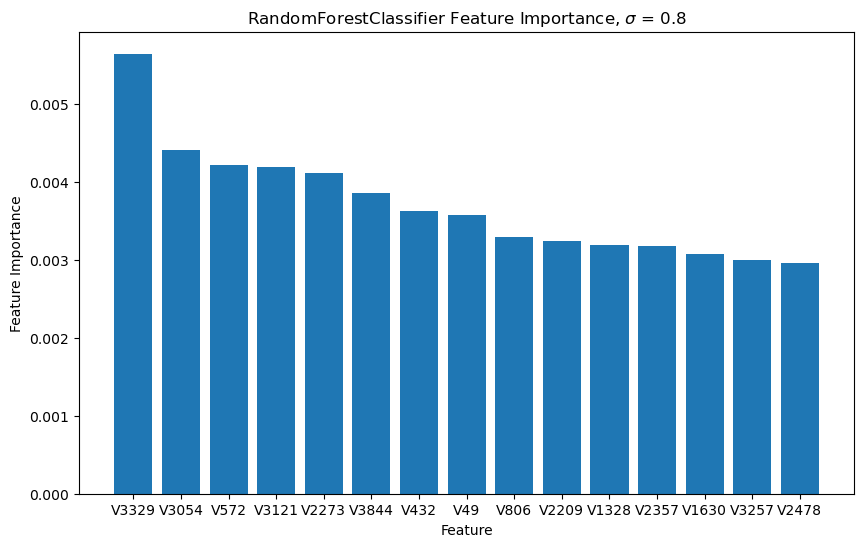

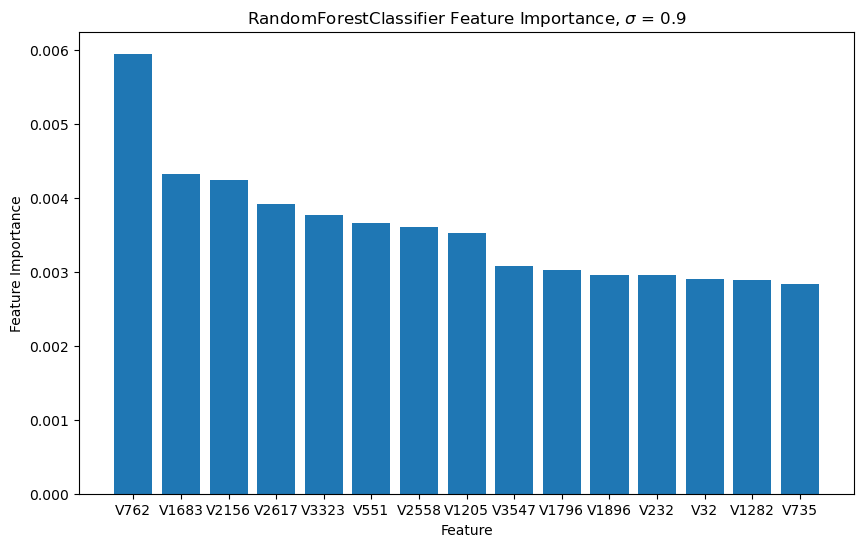

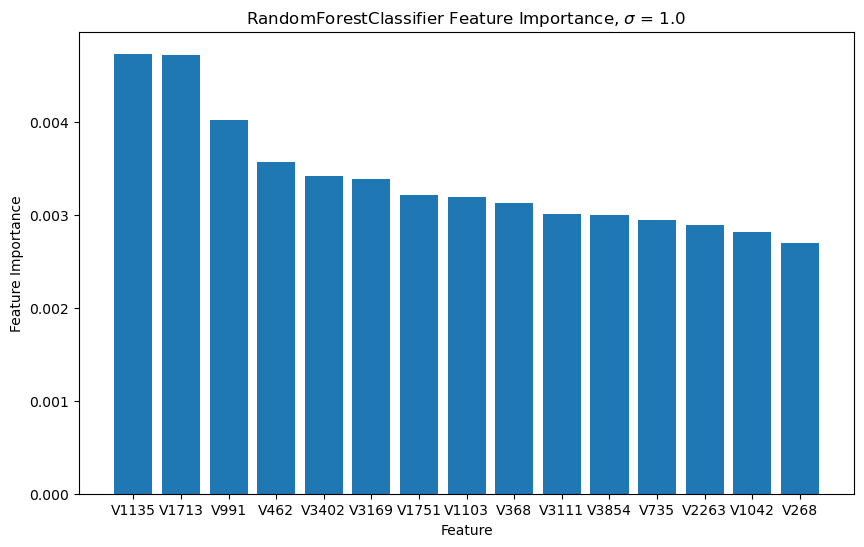

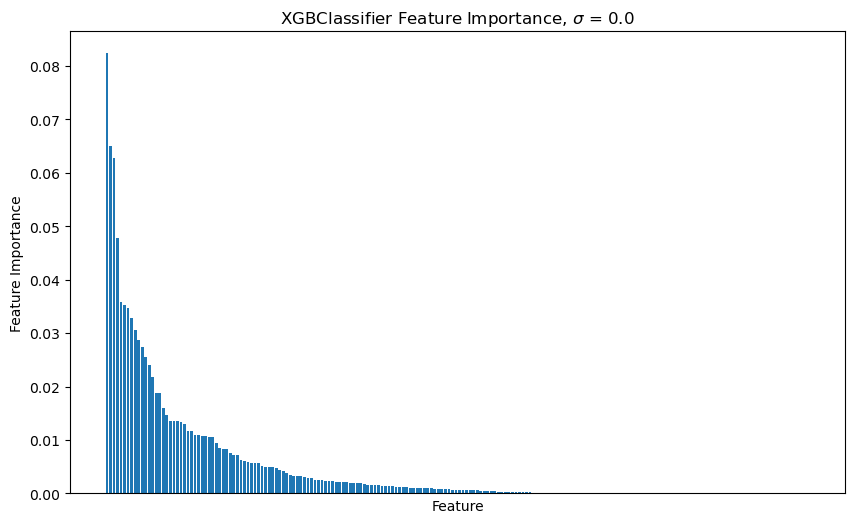

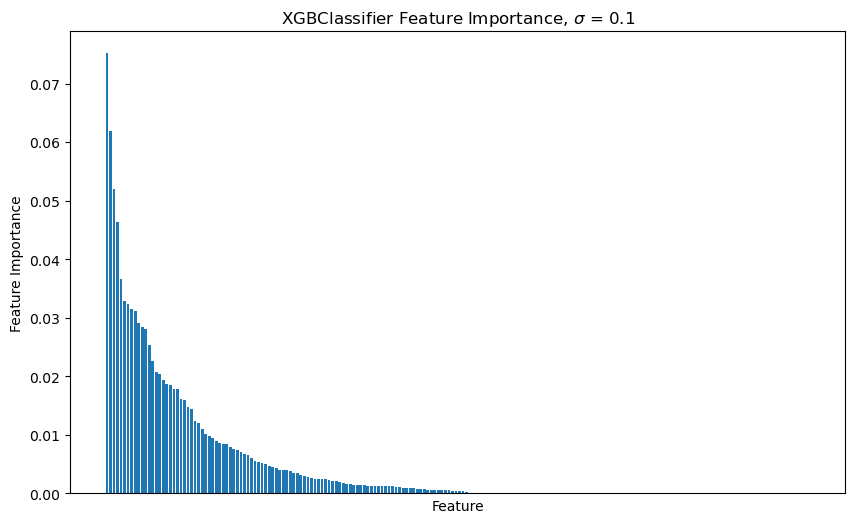

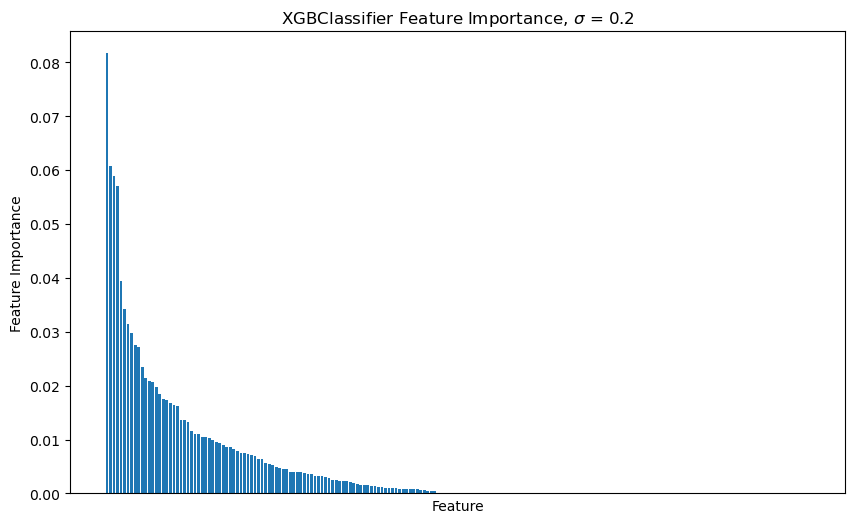

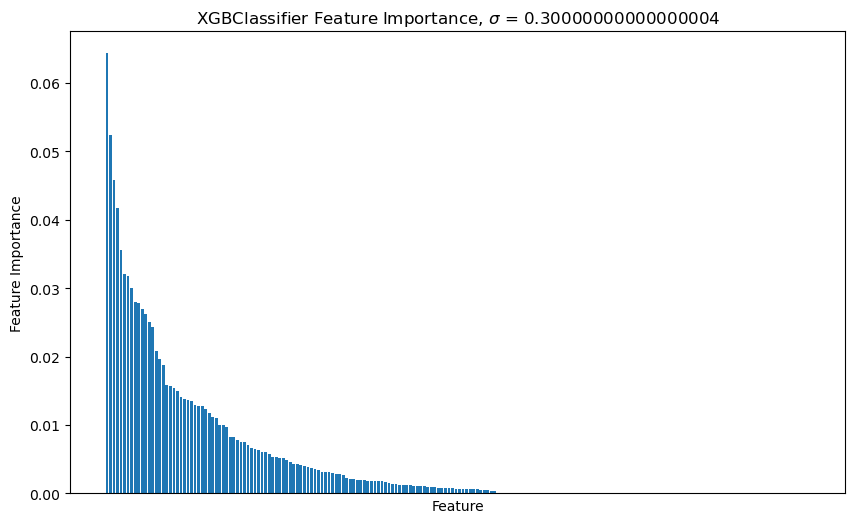

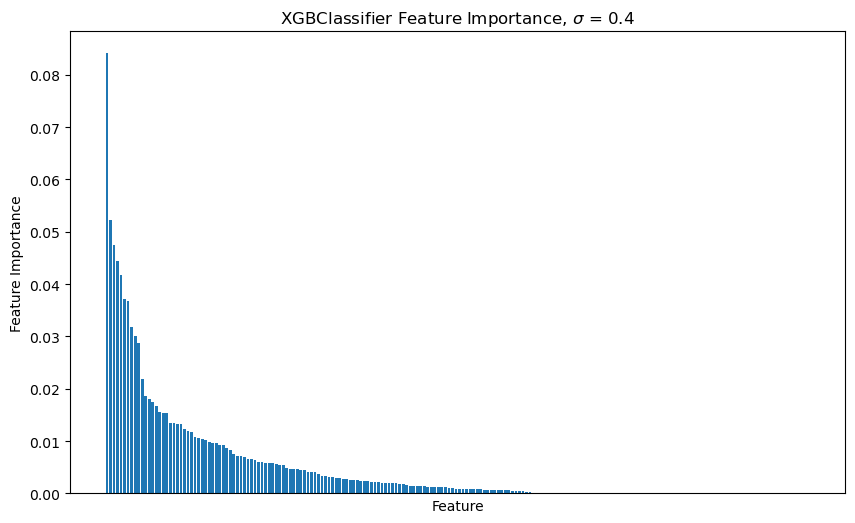

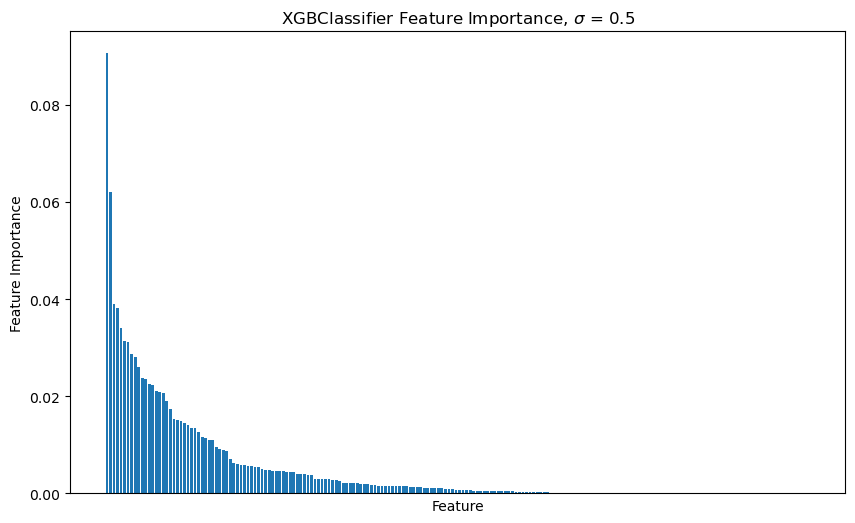

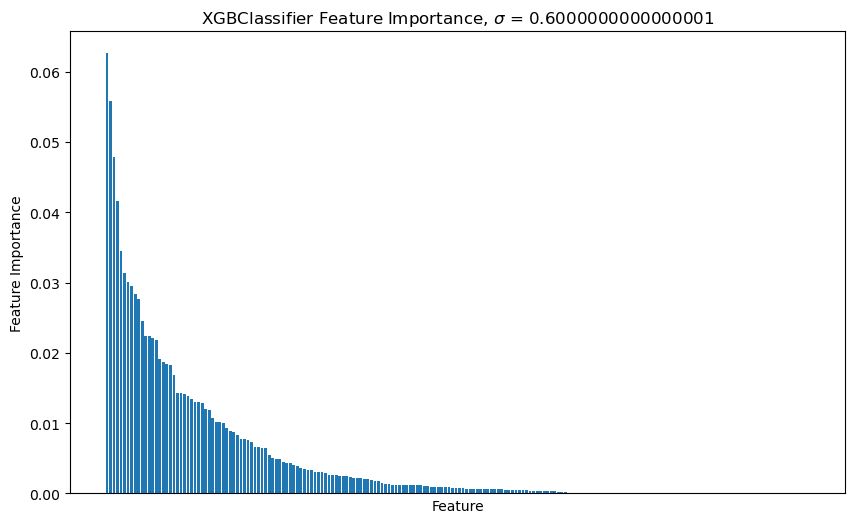

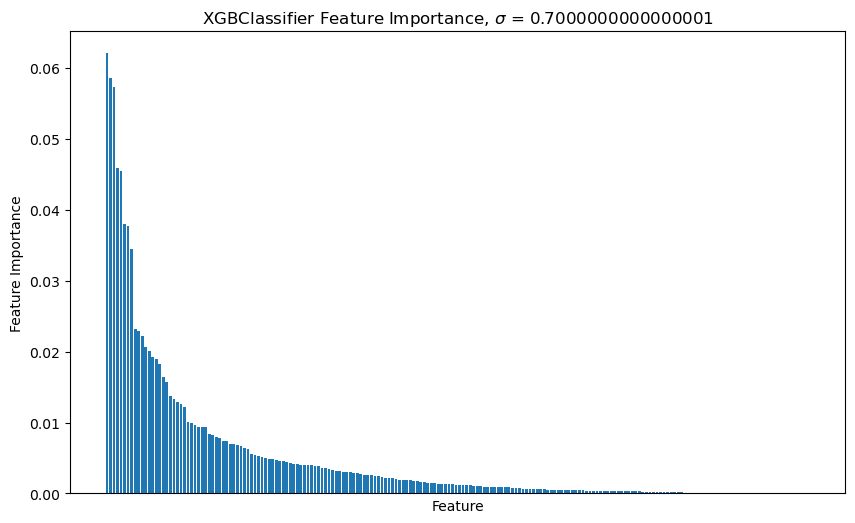

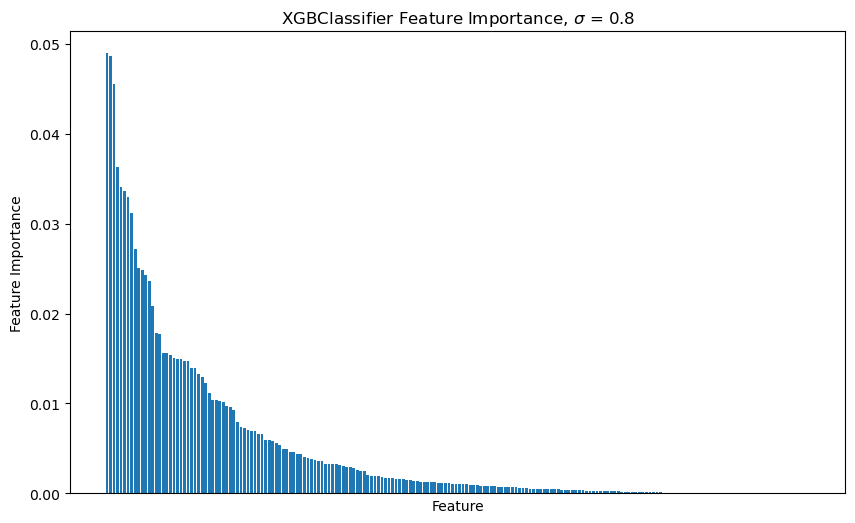

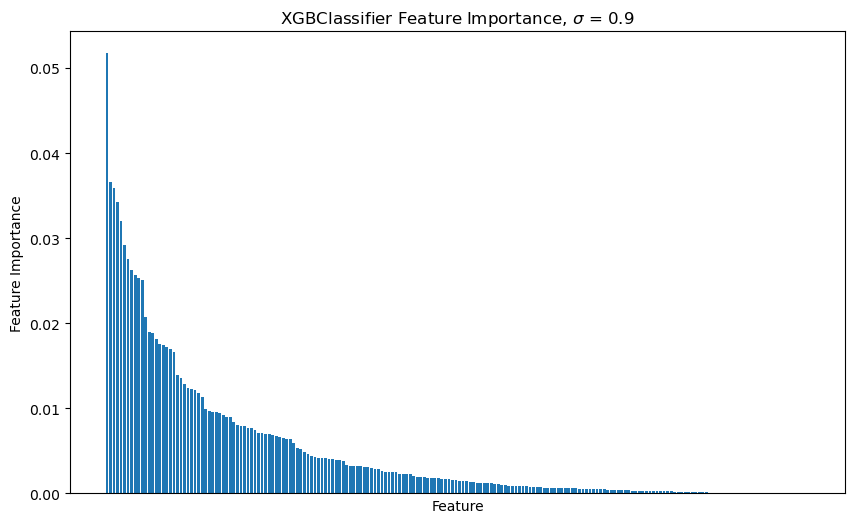

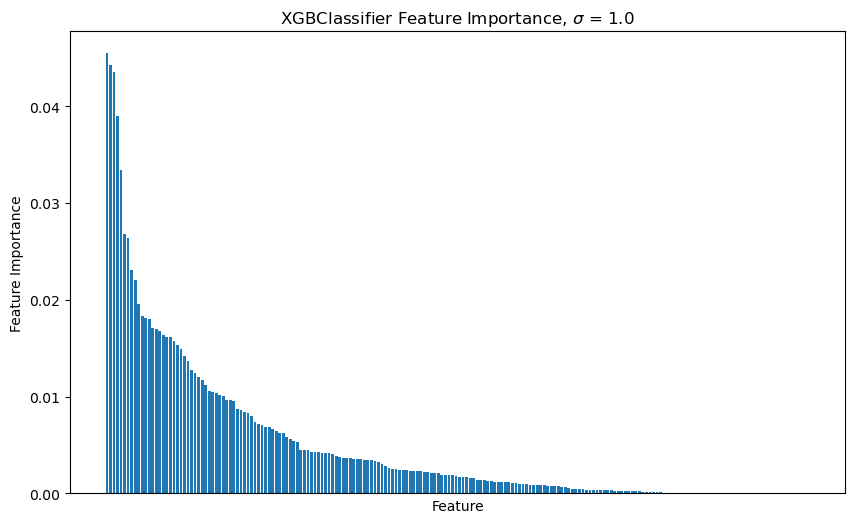

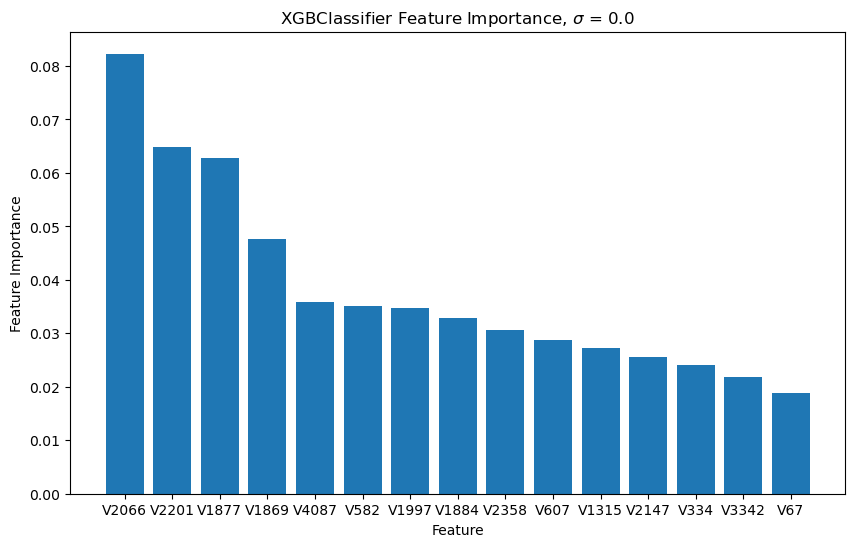

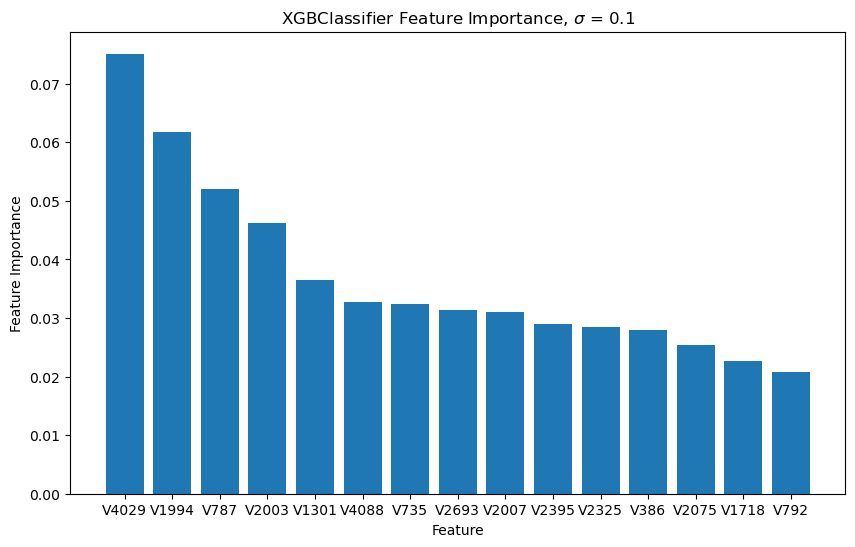

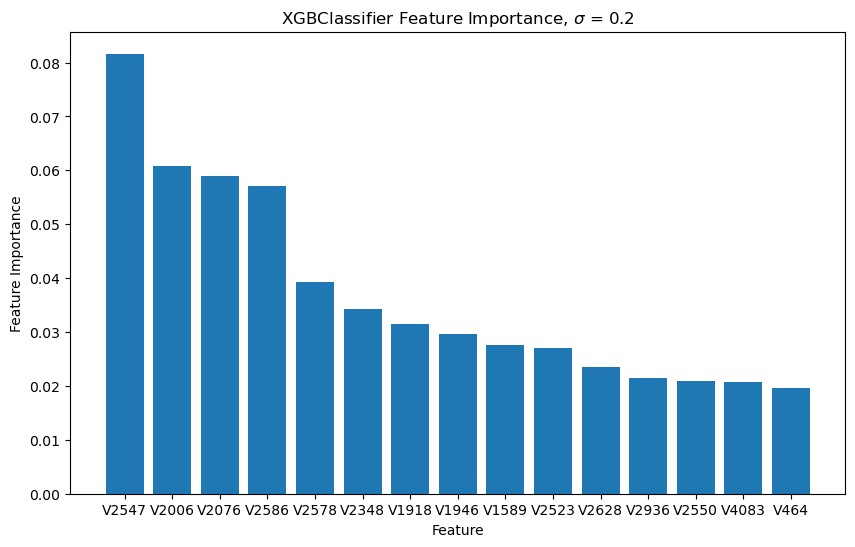

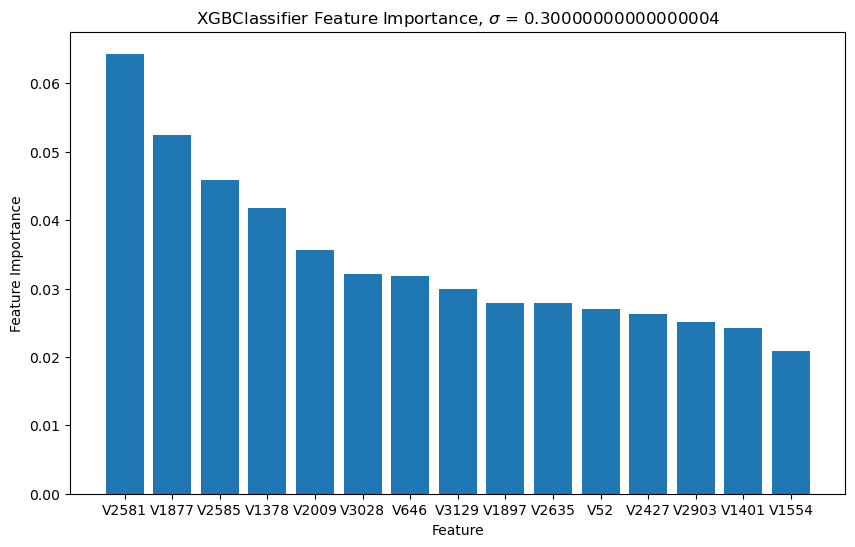

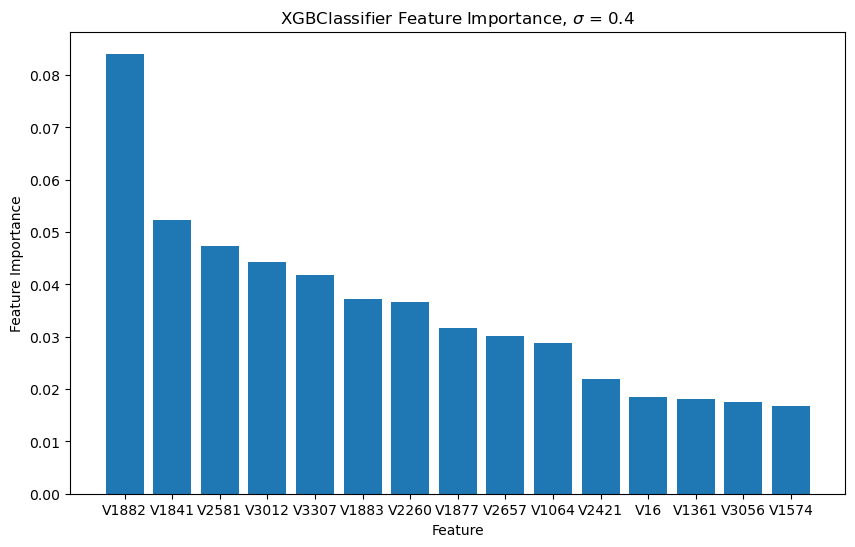

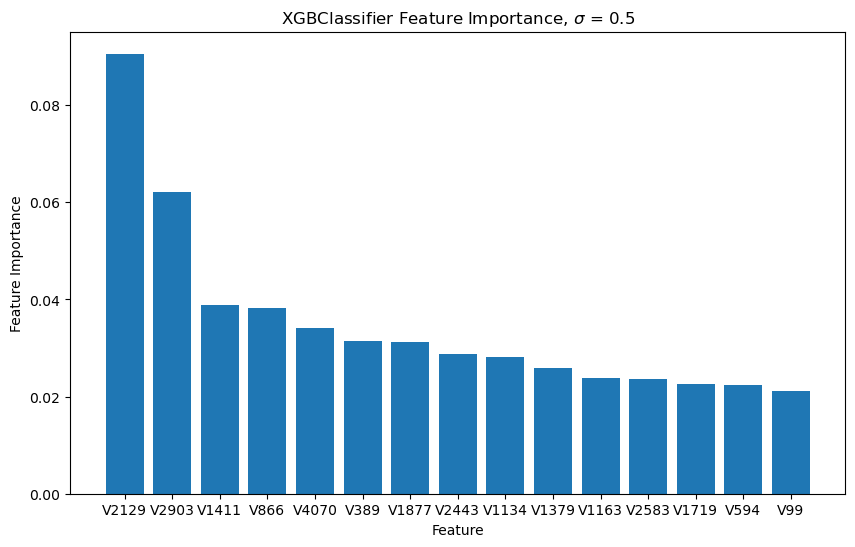

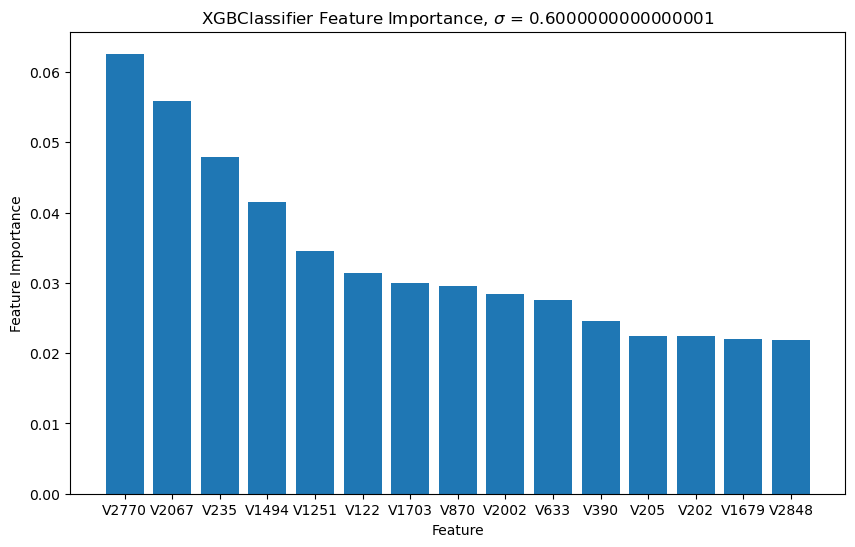

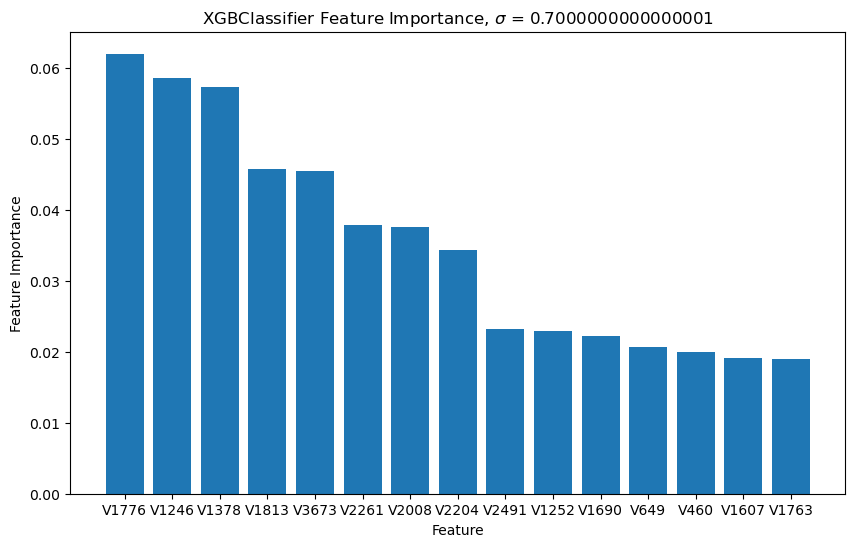

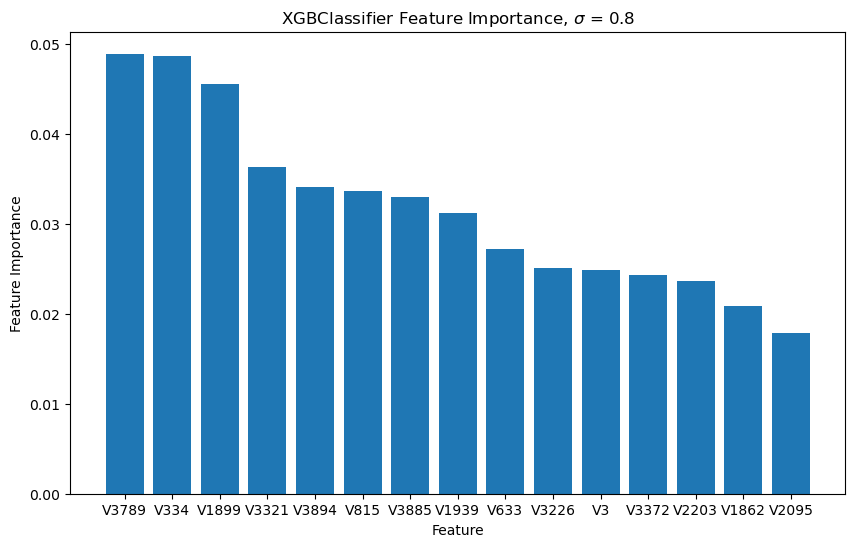

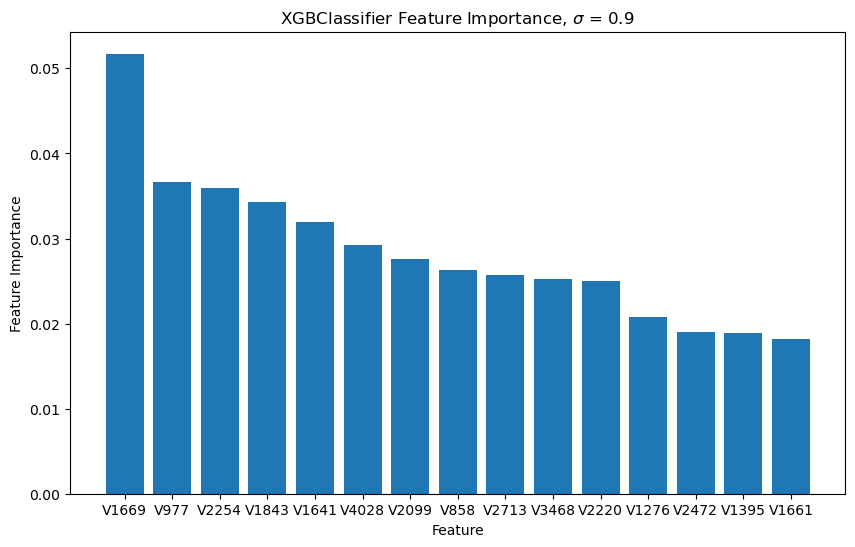

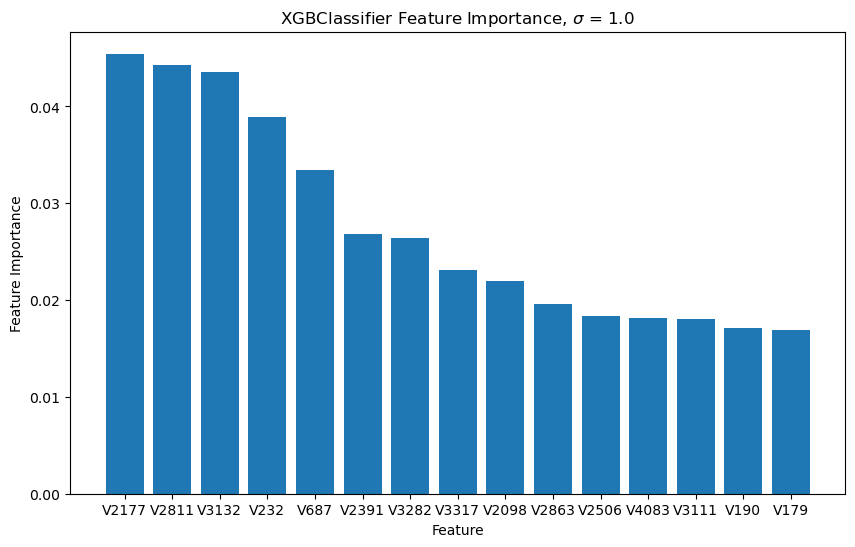

In [280]:

plot_feature_importance(models_replace, cd_features_df_load, noise_percentage, 200, False)
plot_feature_importance(models_replace, cd_features_df_load, noise_percentage, 15, True)

plot_feature_importance(models_replace_xbg, cd_features_df_load, noise_percentage, 200, False)
plot_feature_importance(models_replace_xbg, cd_features_df_load, noise_percentage, 15, True)

The disparity in feature utilization persists in the analysis of image data, akin to the findings observed in the cancer dataset. This discrepancy can be attributed to the distinct mechanisms of the classifiers, where XGBoost prioritizes a narrower set of features, whereas Random Forest employs a broader array. However, despite this difference, the distribution of important features appears to remain consistent across noise levels.

Interestingly, while the overall distribution of feature importance remains stable, there is considerable variation in the specific features deemed important across different noise levels. This phenomenon is likely a consequence of the noise addition process, which involves replacing an increasing number of pixels with "extreme values." As noise levels escalate, the perturbations introduced by these extreme values may disrupt the discernible patterns in the data, leading to fluctuations in the importance of individual features.

Furthermore, without noise, the important features of the data appear to be located predominantly in the middle of the images. However, as noise levels increase, the distribution of important features becomes increasingly random, suggesting a loss of coherence in feature importance.

# Part 2

In [272]:
from sklearn.metrics import recall_score

In [273]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

accuracies = []
recalls = []
f1s= []
scaler = StandardScaler()
scaler.fit(features)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

trees_range = range(1, 50)

for num_trees in trees_range:
    model = RandomForestClassifier(n_estimators=num_trees) 
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')


    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

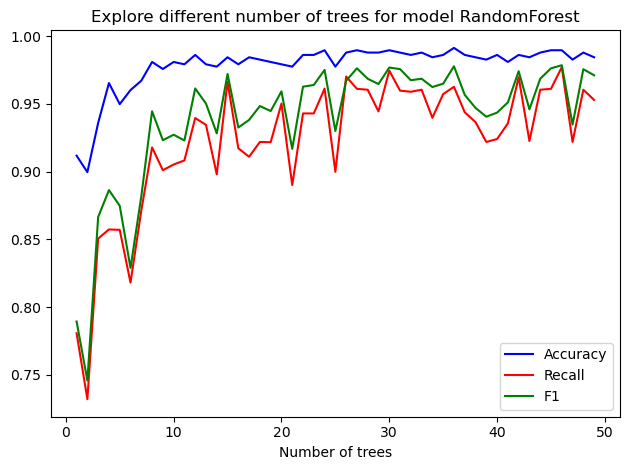

In [274]:

plt.plot(trees_range,accuracies,label='Accuracy', color='blue')
plt.plot(trees_range,recalls,label='Recall', color='red')
plt.plot(trees_range, f1s, label='F1', color='green')
plt.xlabel('Number of trees')
plt.title("Explore different number of trees for model RandomForest")
plt.legend()

plt.tight_layout()
plt.show()

In [275]:
accuracies = []
recalls = []
f1s= []
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

depth_range = range(1, 50)


for num_depth in depth_range:
    model = RandomForestClassifier(max_depth=num_depth)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')


    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

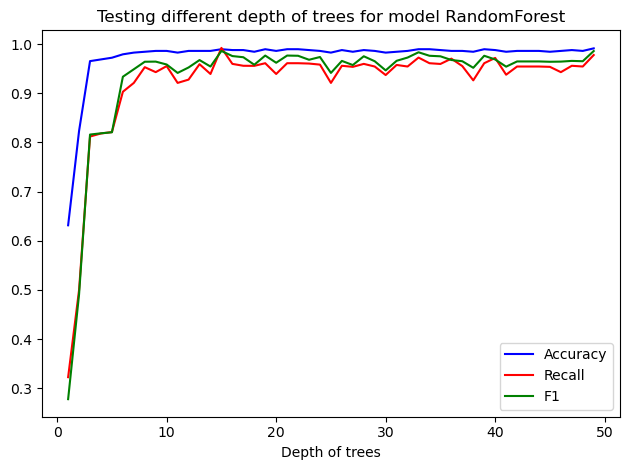

In [276]:
plt.plot(trees_range,accuracies,label='Accuracy', color='blue')
plt.plot(trees_range,recalls,label='Recall', color='red')
plt.plot(trees_range, f1s, label='F1', color='green')
plt.xlabel('Depth of trees')
plt.title("Testing different depth of trees for model RandomForest")
plt.legend()

plt.tight_layout()
plt.show()

In [277]:
accuracies = []
recalls = []
f1s= []
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

sample_range = range(2, 750, 40)

for num_sample in sample_range:
    model = RandomForestClassifier(min_samples_split=num_sample)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')


    accuracies.append(accuracy)
    recalls.append(recall)
    f1s.append(f1)

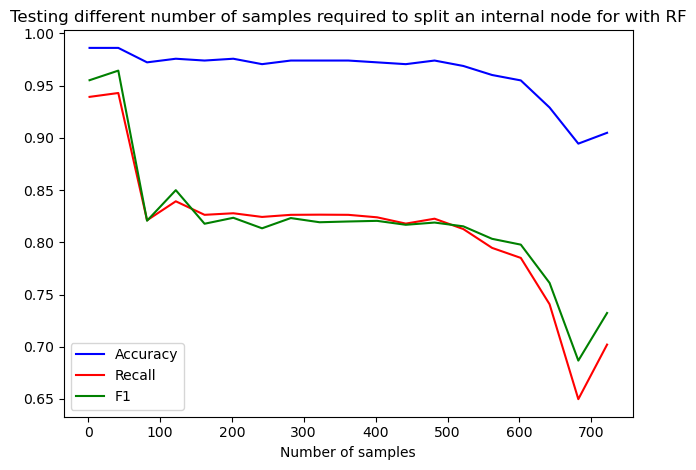

In [278]:
plt.plot(sample_range,accuracies,label='Accuracy', color='blue')
plt.plot(sample_range,recalls,label='Recall', color='red')
plt.plot(sample_range, f1s, label='F1', color='green')
plt.xlabel('Number of samples')
plt.title("Testing different number of samples required to split an internal node for with RF")
plt.legend()

plt.tight_layout()
plt.show()

## Testing permutation importance

In [279]:

from sklearn.inspection import permutation_importance

def calculate_permutation_importance(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    return result

# Calculate permutation importance for each model in the random forest list
subset_models_RF = [models_RF[0], models_RF[2], models_RF[4]]
rf_permutation_importances = []
for rf_model in subset_models_RF:
    rf_permutation_importance = calculate_permutation_importance(rf_model, X_test, y_test)
    rf_permutation_importances.append(rf_permutation_importance)

# Calculate permutation importance for each model in the XGBoost list
subset_models_XGboost = [models_XGboost[0], models_XGboost[2], models_XGboost[4]]
xgb_permutation_importances = []
for xgb_model in subset_models_XGboost:
    xgb_permutation_importance = calculate_permutation_importance(xgb_model, X_test, y_test)
    xgb_permutation_importances.append(xgb_permutation_importance)



RandomForestClassifier()


RandomForestClassifier()
RandomForestClassifier()


KeyboardInterrupt: 

In [ ]:

def plot_permutation_importance(importances, features, models):

    for i in range(len(importances)):
        mean_importances = importances[i].importances_mean
        # Sort feature importances in descending order
        indices = np.argsort(mean_importances)[::-1]
        indices = indices[0:10]


        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.bar(features.columns[indices], mean_importances[indices], align="center")

        plt.xlabel("Feature Index")
        plt.ylabel("Permutation Importance")
        plt.title(type(models[i]).__name__+ r" Permutation Importance, $\sigma$ = ")
    plt.show()

In [ ]:
plot_permutation_importance(xgb_permutation_importances, features_df,subset_models_XGboost)
plot_permutation_importance(rf_permutation_importances, features_df,subset_models_RF)

In [ ]:
subset_models_RF_cd = [models_replace[0], models_replace[2], models_replace[4]]
rf_permutation_importances_cd = []

for rf_model in subset_models_RF_cd:
    rf_permutation_importance = calculate_permutation_importance(rf_model, X_test_cd, y_test_cd)
    rf_permutation_importances_cd.append(rf_permutation_importance)

# Calculate permutation importance for each model in the XGBoost list
subset_models_XGboost_cd = [models_replace_xbg[0], models_replace_xbg[2], models_replace_xbg[4]]
xgb_permutation_importances_cd = []
for xgb_model in subset_models_XGboost_cd:
    xgb_permutation_importance = calculate_permutation_importance(xgb_model, X_test_cd, y_test_cd)
    xgb_permutation_importances_cd.append(xgb_permutation_importance)

In [ ]:
plot_permutation_importance(xgb_permutation_importances_cd, cd_features_df_load, subset_models_XGboost_cd)
plot_permutation_importance(rf_permutation_importances_cd, cd_features_df_load, subset_models_RF_cd)